In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

This is a document that was meant to record some experiments with policy gradients which refers to a class of reinforcement learning techniques. My goal was to get better intuition and I'll transfer more results here over a few days. I am also adding some notes that will hopefully make it useful as a tutorial.

Maybe this should be a latex doc with embedded code, maybe it should be a notebook, maybe it should be a video. I can't decide which one would aid understanding the most, so here is one option that might work well.

It is helpful to have a few jupyter notebook extensions enabled:

* Table of Contents (get floating table on left-side. makes it easy to jump around).

* Collapsible Headings 

## Drive-by View

Suppose, we want a computer to learn the steps to successfully achieve a task. Instead of explicitly programming the computer, we want it to figure a program out on its own. By program here, we don't necessarily mean the actual source code in a language. While we as humans use programming languages to express ideas, it's fruitful to deal directly with mathematics when a computer is learning on its own.

It helps to have a few examples when dealing with a new subject. Imagine the following:

* playing a game - chess, age of empires, pong etc. 

* debugging code

* navigating a robot in a room

* sorting an array

The fourth one is one where we have very efficient algorithms that we can implement directly in a language of our choice. The other three are not so simple. We don't have specific rules or algorithms that we can follow to carry them out. We can try and codify what we would do in those situations but that often leads to catastrophic edge cases and algorithms that don't react well in unknown situations. At this stage, we'll abstract out the core properties of these problems.

## A Closer Drive-by View

One can view all these problems as decision-making processes. How do we make decisions in real life?

* We assess a situation

* We use what we know to decide on and carry out a decision

* We observe a signal that tells us whether what we did was fruitful or not

* Repeat

Real life is messy but maybe it is possible to approximate all decision-making processes by the above framework. To attempt to do so, we need to make each step above more precise.

**"We assess a situation"**:

What does this mean? In the case of a game, we stare at a board or a computer screen and observe the current situation. Our observation, whether described in words or mathematical symbols or pictures, describes everything going on at this moment in time. We usually call this description the **state** of the system we are observing. It is a mathematical object called a **vector** (sorry if this is too pedantic) which you can think of as a collection of $n$ numbers.

**"We use what we know to decide on and carry out a decision"**

We observe the state and make a decision. This process can be encoded as a function that takes in the current as well as past states as inputs and outputs the probabilities of all the possible decisions or **actions** (if finite). We then choose one of these decisions.

This is, of course, easier said than done. After all, this is like describing debugging as the following process: "look at the code and fix it". While technically true, depending on the code base, this is a hard task! What also makes it harder is that we need to take into account not just the state now but at all times in the past. 

We usually have a statistical model (a neural network, linear regression, a random forest) that maps the states (and their history) to the probabilities for each action. This model is called the **policy**.

**"We observe a signal that tells us whether what we did was fruitful or not"**

This is tricky. When you are playing chess and you make a move, sometimes it's obvious that it was a great move or a very bad move. But mostly, it's not that obvious. After all, there's no way to judge a move except for the eventual outcome of winning or losing.

Generally, reinforcement learning problems model a **reward** at every time-step i.e. for each action. This is highly dependent on the problem and often there can be multiple choices. In the chess example, you might assign a reward of +1 if you capture your opponent's piece, -1 if your opponent captures your piece and 0 otherwise (can you think of issues with this definition if you are a chess player?).

In any case, once we have a reward at every time-step, our task is not to maximize this reward. Instead we want to maximize the sum of rewards across **all** time-steps! This is a very crucial point and is what injects the notion of long-term planning into such problems. It is usually easy to do something that maximizes current reward. But that often doesn't lead to long-term reward maximization. For example, capturing pieces greedily in Chess will maximize current reward but you'll most likely lose the game to a well-trained amateur.

So at this stage, we are starting to impose some structure on how we want to describe the problem to a computer.

We have some task. Everything connected to the task is called the **environment**. For chess, it's the chess board. For the robot, it's the robot and the room it is navigating within.

There is a vector describing the **state** of the environment. This tells us everything relevant we need to know about the environment at any point in time and it evolves or changes with time.

There is an **agent** that we focus on. This might be the chess player or our robot. The agent is what we control.

The agent follows a **policy** that tells it what to do in various states. "What to do" refers to **actions** that can be taken.

The eventual goal is to find a policy that maximizes not just the immediate reward for the agent but the long-term total sum of rewards across all time.



## An Even Closer Drive-by View

Consider an abstract, arbitrary state space $\mathcal{S}$. All the possible states are elements of this space. This can be discrete or continuous and can be high-dimensional too. An an example, think of an ant's position on a two-dimensional plane, $\mathbb{R}^2$.

We always start our task at some starting point, $s_0 \in \mathcal{S}$. This can be a fixed point or can be drawn from a distribution $\rho(s)$.

We have a task or goal to achieve. This is modelled as a reward-maximization task. The goal is to take steps or actions from an action space, $\mathcal{A}$ (all actions belong to this set) that lead us to follow trajectories or paths that maximize some (to be made precise below) overall reward. In our example, the goal might be to go from a starting point to an end point in the shortest possible time. This can be rephrased as a maximization problem instead of a minimization problem by the usual identification $\max_x f(x) = \min_x (-f(x))$ (if this is not clear, draw a diagram of an arbitrary function and see what both sides mean geometrically).

Our first key observation is that we keep referring to "current time-step". Time is continuous not discrete! But realistically, all our computing systems treat time as a discrete quantity. It might be a very fine-grained discretization but it is discrete nonetheless and hence, it makes sense to talk about "time-steps".

So, we have time ticking along at a regular rate (not how the universe works but unless we are working with relativistic objects, it's a very good approximation). At each step, we observe the state of our environment, pick an action recommended by the policy, get an immediate reward and observe the next state. This loop repeats either indefinitely or till a natural stopping point in time. This gives us a sequence:

$$s_1 \rightarrow a_1 \rightarrow r_1 \rightarrow s_2 \rightarrow a_2 \rightarrow r_2 \rightarrow \ldots $$

or for arbitrary time,

$$\ldots \rightarrow s_t \rightarrow a_t \rightarrow r_t \rightarrow \ldots $$

Our goal is to maximize the total reward:

$$R = r_1 + r_2 + r_3 + \ldots + r_t + \ldots$$

**Pedantic Note**:

This is usually condensed using a capital-Sigma (Greek "S" letter, "S" for sum) to:

$$R = \Sigma_{t=1}^{T} r_t$$

where $T$ is when the experiment ends or can be $\infty$ if the experiment never ends. Often, it is onerous to carry around the index and it is suppressed:

$$R = \Sigma_t r_t = \Sigma r_t$$

**End of Pedantic Note**

To make this more transparent, the only thing **we** (the agent and the policy running the agent) control in the sequence:

$$\ldots \rightarrow s_t \rightarrow a_t \rightarrow r_t \rightarrow \ldots $$

are the actions, $a_t$. The action at a given time-step might depend on the current state, $s_t$ as well as all the historical states, $s_1, s_2, \ldots, s_{t-1}$. Here is where we make our second assumption. We will only, in theory at least, deal with so-called **Markov** systems. What does this mean? Very simply, it means that the state at time $t+1$ only depends on the state and action at time $t$. Nothing prior to time $t$ matters for this transition from $t \rightarrow t+1$. 

What is the motivation for making this assumption? A big benefit is ease of mathematical reasoning. Often, the art of mathematically modeling a system, whether in physics or finance or biology, is to consider just enough information about the system to (1) be able to mathematically solve the equations one uses to describe the system, (2) be able to describe the system's behavior within a tolerable error.

Another benefit often is that some systems have been extensively studied before and if one is justified in making an assumption that our system belongs to one of these previously-studied systems, it opens up a vast arsenal of results that we can rely upon.

A quick work about Markov systems. Forget about all our discussion of reinforcement learning. Suppose, we are given a state space, $\mathcal{S}$. The state changes in time:

$$s_1 \rightarrow s_2 \rightarrow s_3 \rightarrow \ldots \rightarrow s_t \rightarrow \ldots$$ 

The probability that we get a given state $s_{t+1}$ at time $t+1$ will depend on all the prior states:

$$\mathbb{P}[s_{t+1} | s_1, s_2, \ldots, s_t]$$

The **Markov assumption** is that this probability is actually independent of all states except $s_t$:

$$\mathbb{P}[s_{t+1} | s_1, s_2, \ldots, s_t] = \mathbb{P}[s_{t+1}|s_t]$$

This implies that if the state space is discrete, we can write a so-called **transition matrix**, $P$ with $ij-$th element being the probability:

$$\mathbb{P}[s_{t+1}=j | s_t=i]$$

At time $t+1$, we have to land in some state, so

$$\Sigma_j P_{ij} = \Sigma_j \mathbb{P}[s_{t+1}=j | s_t=i] = 1$$

We won't discuss Markov processes (also called Markov chains) in more detail here.

Going back to reinforcement learning, this assumption translates into the idea that the state at time $t+1$ only depends on the state at time $t$ and the action at time $t$. As we will see later, this is a crucial assumption to make progress with policy gradients. At the same time, one should naturally ask if this is a valid assumption. Are most real systems Markov? Our intuition might tell us that what happens in real-systems depends on the history the system went through and not just what happened at the previous time-step.

The real answer is that we rarely know at the outset if a system is Markov or not. We always have the freedom to re-define the definition of state: $s'_t = (s_t, s_{t-1})$ in which case a new state $s'$ concatenates the old state at two (or more) time-steps! A concrete example is that of Atari video-games like Pong. Instead of training an agent by making it look at just one frame of the game (in which case one loses all information about the velocity of the ball), one takes the difference of two consecutive frames to define a new frame (or state).

Going back to the sequence:

$$\ldots \rightarrow s_t \rightarrow a_t \rightarrow r_t \rightarrow \ldots $$

the only element we (the agent) control is $a_t$ chosen by the policy. Practically, the policy is represented by a statistical model, denoted $\pi(a_t|s_t, \theta)$ or $\pi_{\theta}(a_t|s_t)$. You should imagine a linear regression or neural network here (as a couple of examples). $\theta$ denotes the set of parameters - coefficients for linear regression and weights and biases for neural networks - that need to be tuned and chosen. The notation $(a_t | s_t)$ is standard probability notation to be read as "a_t given s_t". In other words, $\pi_{\theta}(a_t|s_t)$ is a model that predicts the probability distribution of different actions that can be taken at time $t$ given knowledge about the state at time $t$.

Our final goal then is to choose $\theta$ such that if $\pi_{\theta}(a_t|s_t)$ is used to pick actions, then **on average**, we will get sequences or trajectories:

$$\ldots \rightarrow s_t \rightarrow a_t \rightarrow r_t \rightarrow \ldots $$

that lead to maximal overall reward:

$$R = r_1 + r_2 + \ldots$$

## Finer Points

(not relevant for now)

gamma

time

state space

action space

reward structure

MDPs

# Policy Gradients

While we discussed reinforcement learning, we didn't discuss how we would actually find the optimal policy, $\pi(a_t|s_t, \theta)$. **Policy gradient methods** describe a general set of techniques to directly change the policy to maximize the expected (more on this) reward.

Suppose, we consider the space of all trajectories:

$$\tau \equiv s_1 \rightarrow a_1 \rightarrow r_1 \rightarrow s_2 \rightarrow a_2 \rightarrow r_2 \rightarrow \ldots $$

The only element we control are the actions $a_t$ through the policy $\pi$. In principle, we could run across every single trajectory, measure its total reward and store it in a gigantic table. Then, given a start state $s_1$, we would look at all trajectories starting from $s_1$, and pick the action from the trajectory with the highest reward (from the table). This process can be repeated as long as we have the table. Of course, this is prohibitive because (1) even if the state and action spaces are discrete, the number of trajectories is huge!, (2) since our actions are stochastic, we can't actually guarantee that a certain action will lead to a certain state.

What do we do instead? Each trajectory has a certain total reward associated with it. Every time we run with a certain policy i.e. use a policy to choose the actions $a_t$, we get one sample trajectory. We can't guarantee that there is the best or optimal policy that always puts us on the trajectory with the maximum reward but we can try aiming to get the maximal average (or expected) reward. As an analogy, if you are a world-class tennis player, we can't guarantee a training regime that will ensure you win every game you ever play. There is some randomness to that process (you have a bad day, you are injured etc.) but we can at least aim to ensure that on average your likelihood to win is as high as possible.

In mathematical terms, the average or expected total reward is given by:

$$J \equiv \Sigma_{\tau} R(\tau) P(\tau; \theta)$$

**Pedantic Aside**:

An average or mean of n numbers is simply:

$$\bar{x} = \frac{x_1 + \ldots + x_n}{n}$$

Imagine we have k distinct values, $x_1, x_2, \ldots, x_k$ each occuring $n_1, n_2, \ldots, n_k$ times. We have $n_1 + \ldots + n_k = n$.

We can rewrite the average as:

$$\bar{x} = \frac{x_1 n_1 + x_2 n_2 + \ldots + x_k n_k}{n} = x_1 p_1 + \ldots + x_k p_k$$

where $p_i = \frac{n_i}{n}$ is the probability of getting a measurement, $x_i$. The continuous version of this is:

$\bar{x} = \int dx x p(x)$

where $p(x)$ is a probability distribution function (p.d.f.) i.e. $p(x) \geq 0$ and $\int dx p(x) = 1$.

Lastly, the average or expected value of a function of the inputs would be:

$$\bar{f(X)} = \mathbb{E}f(X) \equiv \Sigma_{x} f(x)p(x)$$

where $\mathbb{E}$ denotes the expected value. In this notation, we have

$$J = \mathbb{E}R = \Sigma_{\tau} R(\tau) P(\tau; \theta)$$

**End of aside**

This equation packs a lot of meaning so let's decode it. We are summing over all trajectories, $\tau$. That is computationally infeasible but that's not relevant right now. $R(\tau)$ denotes the total reward for some trajectory:

$$\tau \equiv s_1 \rightarrow a_1 \rightarrow r_1 \rightarrow s_2 \rightarrow a_2 \rightarrow r_2 \rightarrow \ldots $$

$$\implies R(\tau) = r_1 + r_2 + r_3 + \ldots$$

$P(\tau; \theta)$ denotes the total probability of a trajectory. This is where the Markov property is very useful. Because each time-step depends only on the previous one, we can treat different times as independent and write:

$$P(\tau) = \underbrace{{\rho(s_1)}}_{\text{initial dist.}} \underbrace{\pi(a_1|s_1)}_{\text{policy}}\underbrace{\rho(s_2|s_1,a_1)}_{\text{dynamics}} \underbrace{\pi(a_2|s_2)}_{\text{policy}} \underbrace{\rho(s_3|s_2,a_2)}_{\text{dynamics}}\ldots$$

Each term above is a probability. The policy tells us the probabilities of taking various actions. Dynamics are something intrinsic to the system. $\rho(s_t|s_{t-1},a_{t-1})$ describes how a system evolves in time or how its state changes with time. This is exactly what a lot of physics is all about. We want to discover how planets will orbit with time or how a hydrogen atom will behave over time. If something is known about the dynamics of our environment, we can and maybe even should (depending on how complex it is) exploit it. But we will generally assume that nothing is known about the dynamics a priori.

We want to maximize, $J = \Sigma_{\tau} R(\tau) P(\tau; \theta)$ but (1) we can't sum over all trajectories and (2) we don't know the initial distribution $\rho(s_1)$ as well as the dynamics $\rho(s_t|s_{t-1}, a_{t-1})$. So how we do make progress?

The first key observation is that the only thing we control is $\theta$. These are the parameters of the policy. We can't control the dynamics because they are intrinsic to the environment/system. A corollary is that since we control $\theta$ (the policy's parameters), we are maximizing a quantity, $J = \Sigma_{\tau} R(\tau) P(\tau; \theta)$ by purely adjusting $P(\tau; \theta)$ i.e. the probability distribution over the trajectories. Our policy's job is to ensure we are far more likely to lie on the high-reward trajectories than the low-reward ones.

The second observation comes from a straightforward choice. We have a function $J(\theta)$ that we want to maximize. If we can take the first derivatives with respect to $\theta$, then we could use gradient ascent.

**Aside**:

At its core, gradient descent/ascent is remarkably simple. Suppose you have a function, $f(x)$ of one variable. Also, suppose it is differentiable. Then we can see from the following picture:

![](media/gradientdescent.svg)

that we should always move opposite to the direction of the derivative. If the derivative is positive, we should move in the negative direction to decrease the function. If the derivative is negative, we should move in the positive direction to decrease the function.

So, we can write an iterative algorithm where we start with some initial guess $x_0$ and then update it according to:

$$x_t = x_{t-1} - \frac{df}{dx}(x_{t-1})$$

Usually we want to control how far we move and that's done by introducing a step-size or learning rate, $\eta$.

$$x_t = x_{t-1} - \eta \frac{df}{dx}(x_{t-1})$$

Another way of stating this is to say that we are locally approximating our function as a linear function (a line) and moving along the line. The further we move away from our current point, the worse the linear approximation will get and so we want to control how far we move.

A key point here is that since we are only exploiting local (derivative) information, we will most likely get stuck in a local minimum not the global minimum. In general, there is no information in the derivative at a point about the global behavior of the function.

For functions that depend on many variables, $f(x_1, x_2, \ldots, x_n)$, there is a very straightforward generalization.

$$f(x_1^{t}, x_2^{t}, \ldots, x_i^{t}, \ldots, x_n^{t}) = f(x_1^{t-1}, x_2^{t-1}, \ldots, x_i^{t-1}, \ldots, x_n^{t}) - \eta \frac{\partial f}{\partial x_i}(x_1^{t-1}, x_2^{t-1}, \ldots, x_i^{t-1}\ldots, x_n^{t-1})$$

These partial derivatives form a vector called the gradient:

$$\nabla f(x_1,\ldots,x_n) = (\frac{\partial f}{\partial x_1}, \ldots, \frac{\partial f}{\partial x_n})$$

and we write gradient descent in the more compact notation:

$$\vec{x}^{t} = \vec{x}^{t-1} - \eta \nabla f(\vec{x}^{t-1})$$

Geometrically, we have some curved surface ("manifold") which we are approximation locally as a plane. The gradient vector points in the direction of maximal increase and so we move along/opposite the gradient by a step-size $\eta$ for gradient ascent/descent.

**End of aside**

To use gradient descent, we need the gradient of $J$ with respect to $\theta$ (which is generally a vector i.e. we have many weights that our policy depends on).

So,

$$\nabla_{\theta} J(\theta) = \nabla \Sigma_{\tau} R(\tau) P(\tau; \theta)$$

Derivatives are linear operations i.e. $\frac{d}{dx}(f(x) + g(x)) = \frac{df}{dx} + \frac{dg}{dx}$ so the derivative of the sum is the sum of derivatives:

$$\nabla_{\theta} J(\theta) = \Sigma_{\tau} \nabla[R(\tau) P(\tau; \theta)]$$

$R(\tau)$ doesn't depend on $\theta$. Once the sequence of states and actions (which describes the trajectory) is fixed, changing $\theta$ won't change the total reward, $R(\tau)$. So,

$$\nabla_{\theta} J(\theta) = \Sigma_{\tau} R(\tau) \nabla P(\tau; \theta)$$

So far so good. Now it is generally ideal to write quantities as expected values because as we will see soon, averages can be estimated from samples which can be generated by Monte-Carlo simulations. Expected values have the structure $\mathbb{E}f(X) = \Sigma f(x) p(x)$.

We instead have $\nabla P(\tau; \theta)$. Can we write this as $P(\tau; \theta) * \text{something}$? The analog of this would be the question:

Can you write $\frac{df}{dx}$ as $f(x) * \text{something}$? Let's try this out.

Suppose, $\frac{df}{dx} = G(x) f(x)$ for some unknown $G(x)$. Then,

$$\frac{df}{f(x)} = G(x) dx$$

Integrating both sides, we get

$\log|f(x)| = \int G(x) dx$

or (using the fundamental theorem of calculus),

$$G(x) = \frac{d\log|f(x)|}{dx}$$

Of course, you could have just guessed this from above or verified it knowing that:

$$\frac{d\log |f(x)|}{dx} = \frac{1}{|f(x)|} \frac{df}{dx}$$

The same calculation holds for the gradient and we get:

$$\nabla_{\theta} J(\theta) = \Sigma_{\tau} R(\tau) \nabla [\log P(\tau; \theta)] P(\tau; \theta)$$

Now we can write this as an expectation:

$$\nabla_{\theta} J(\theta) = \mathbb{E}_{\tau} R(\tau) \nabla\log P(\tau; \theta)$$

where $\mathbb{E}_{\tau}$ makes it explicit that the average is taken over all trajectories. Why did we go through this trouble of writing our sum as an expectation? In its original form:

$$\nabla_{\theta} J(\theta) = \Sigma_{\tau} R(\tau) \nabla P(\tau; \theta)$$

it wasn't obvious at all that we could compute this. How are we supposed to get $\nabla P(\tau)$? By writing it as an expectation, we can use use the machinery of Monte-Carlo to estimate the expected value i.e. $\nabla J(\theta)$.

### Monte-Carlo Simulations

Consider the problem of computing an expected value of some quantity, $X$ following a probability distribution function (p.d.f.) $p(x)$. Mathematically, we want to compute the integral:

$$I = \int_{-\infty}^{\infty} dx p(x) f(x)$$

The problem is that we don't know $p(x)$! If we did, maybe we could do some kind of discrete approximation:

$$I \approx \Sigma_{x_i} p(x_i) f(x_i)$$

where $x_i = i * \delta$ for some fixed lattice spacing $\delta$ on the one-dimensional real line and $i$ is an integer.

But an elegant way presents itself. What if we can **sample** various values of X?! If the samples are drawn from the distribution $p(x)$ (the histogram of $n$ samples gets closer to $p(x)$ as $n$ gets larger) and we have a way of drawing more samples when we desire, then we can approximate $I$ as:

$$\hat{I} \approx \Sigma_{x\sim p} f(x_i)$$

This might be confusing if it's the first time you are seeing this so let's pick an example. Suppose you want to measure the average height of people in a country, C. This would be:

$$\bar{h} \equiv \mathbb{E}H = \int_0^{\infty} dh h p(h)$$

where $p(h)dh$ = probability that a person has height between $h$ and $h+dh$.

We don't know $p(h)$ a priori but we just sample i.e. randomly pick $n$ people from the population. As long as the sample is random, the probabilility distribution of our sample will be similar to the actual distribution $p(h)$. BETTER EXPLANATION

There are some core questions one would want to answer. (1) What is the error between the Monte-Carlo (MC) estimate, $\hat{I}$ and the actual value, $I$. We expect this error to vanish (go to 0) as the sample size $n$ increases but how fast does it vanish? (2) What is the variance of $\hat{I}$? If we picked $k$ different samples of size $n$ each, each sample would have a different estimate $\hat{I}_k$. Hopefully, on average, these $I_{k}$ will be equal to the true value, $I$ (zero bias) but what about the variance in the values $I_k$? Can we minimize that?

Monte-Carlo Methods are a beautiful and deep topic that have multiple applications. We won't go any deeper here but further study of the topic is highly recommended.

Recall, our central object of interest was:

$$\nabla_{\theta} J(\theta) = \mathbb{E}_{\tau} R(\tau) \nabla\log P(\tau; \theta)$$

If we can compute this gradient, we can use gradient ascent (not descent) to maximize (not minimize) $J(\theta)$. Since we wrote it as an expectation, we might be able to use Monte-Carlo sampling which doesn't require the explicit knowledge of the underlying probability distribution to generate $n$ trajectories (also known as **rollouts**) from our policy and then estimate $\nabla_{\theta} J(\theta)$. But we still have a problem. Unlike the simple MC example given above where $f(x_i)$ didn't depend on $p(x)$, here $f(X) = R(\tau) \log P(\tau; \theta)$ i.e. it depends on $p(x)$. So maybe we are really stuck. We don't know $P(\tau)$ and need it to estimate the gradient even by MC methods.

Let's look at $\log P(\tau)$ in more detail. Recall:

$$P(\tau) = \underbrace{{\rho(s_1)}}_{\text{initial dist.}} \underbrace{\pi(a_1|s_1)}_{\text{policy}}\underbrace{\rho(s_2|s_1,a_1)}_{\text{dynamics}} \underbrace{\pi(a_2|s_2)}_{\text{policy}} \underbrace{\rho(s_3|s_2,a_2)}_{\text{dynamics}}\ldots$$

Logs have the nice property of mapping products to sums i.e.: $\log(ab) = \log(a) + \log(b)$.

$$\log P(\tau) = \log\rho(s_1)+ \log \pi(a_1|s_1) + \log\rho(s_2|s_1,a_1) + \log\pi(a_2|s_2) + \log\rho(s_r|s_2,a_1) + \ldots$$

Note that the only terms that depend on $\theta$ are the ones with the policy, $\pi$! The derivatives with respect to $\theta$ for the other terms are 0! So,

$$\nabla_{\theta}\log P(\tau) = \nabla_{\theta}\log\rho(s_1)+ \nabla_{\theta}\log \pi(a_1|s_1) + \nabla_{\theta}\log\rho(s_2|s_1,a_1) + \nabla_{\theta}\log\pi(a_2|s_2) + \nabla_{\theta}\log\rho(s_r|s_2,a_1) + \ldots$$

$$\implies \nabla_{\theta}\log P(\tau) = \nabla_{\theta}\log \pi(a_1|s_1) + \nabla_{\theta}\log\pi(a_2|s_2) + \ldots$$

I am not using $\Sigma$ explicitly to keep the notation out of the way in case the reader is just getting familiar with it. This is usually written as:

$$\implies \nabla_{\theta}\log P(\tau) = \Sigma_{i=1}^{T}\nabla_{\theta}\log \pi(a_i|s_i)$$

This is a key breakthrough. The structure of $P(\tau)$ depended on the initial distribution of states, $\rho(s)$ as well as on the dynamics, $\rho(s_t|s_{t-1},a_{t-1})$ which are both generally unknown. It would be a tall order to find out the exact dynamics of an arbitrary environment. Maybe we could empirically approximate it by doing many experiments. But what we found is that we actually don't need dynamics to compute the gradient needed for gradient ascent. All we need is the policy which is completely under our control.

Now we have:

$$\nabla_{\theta} J(\theta) = \mathbb{E}_{\tau} R(\tau) \nabla \log P(\tau; \theta) = \mathbb{E}_{\tau} R(\tau) \left(\Sigma_{t=1}^{T} \nabla\log \pi(a_t|s_t)\right) = \boxed{\mathbb{E}_{\tau} \left(\Sigma_{t=1}^{T} r_t\right) \left(\Sigma_{t=1}^{T} \nabla\log \pi(a_t|s_t)\right)}$$

where we used $R(\tau) = r_1 + r_2 + \ldots + r_T = \Sigma_{t=1}^T r_t$.

At this stage, we can use Monte-Carlo to estimate this expected value. Just like we estimated the average height, $\mathbb{E}H \approx \frac{h_1 + \ldots + h_n}{n}$ by sampling $n$ random people, we can estimate $\nabla_{\theta} J(\theta) = \mathbb{E}_{\tau} \left(\Sigma_{t=1}^{T} r_t\right) \left(\Sigma_{t=1}^{T} \nabla\log \pi(a_t|s_t)\right)$ by sampling $n$ random *trajectories* using actions taken from our policy. In other words,

$$\nabla_{\theta} J(\theta) \approx \frac{1}{n}\Sigma_{i=1}^{n} \left(\Sigma_{t=1}^{T} r_t^{(i)}\right) \left(\Sigma_{t=1}^{T} \nabla\log \pi(a_t^{(i)}|s_t^{(i)})\right)$$

The index $i$ runs over the $n$ sampled trajectories. There is a superscript on each state and action indicating which trajectory it comes from. If this is too confusing, consider one trajectory. We can start in a start state (either fixed or from a chosen distribution). Our current policy (with parameters $\theta$) gives us the probability distribution on the possible actions one can take from the current state. We sample one of these actions which "takes us to a new state" (more on this in a moment) and gives us an immediate reward, $r_1$. We can again use our policy to sample an action and repeat this process for time-period $T$. This is one sampled trajectory.

We can compute the total reward for this trajectory from the $r_t$. Since we know what actions we took and since we know the probabilities of taking those actions from our policy, we can compute $\log \pi_{\theta}(a_t|s_{t-1})$ and thus the derivatives of this with respect to $\theta$: $\nabla_{\theta}\log \pi_{\theta}(a_t|s_{t-1})$. Repeating this for each time-step gives us the quantity: $\left(\Sigma_{t=1}^T r_t\right)\left(\Sigma_{t=1}^T \nabla_{\theta}\log\pi(a_t|s_t)\right)$

We can do this for $n$ trajectories, average these products of sums, and get an estimate of $\nabla_{\theta} J(\theta)$. This would be used to update our policy:

$$\theta_{t+1} = \theta_{t} + \eta \nabla_{\theta} J(\theta)$$

where $\theta_{1}$ is the set of parameters for the initial policy, which is updated through time.

Above, we mentioned that taking an action "takes us to a new state". Recall that the new state depends on the dynamics, $\rho(s_t|s_{t-1},a_{t-1})$ which we usually don't know! So how do we know which state to go to? We usually do these experiments either in real-life or a simulator. In real-life, the dynamics are of course, "built in". An accurate simulator will mimic real-life closely but with the advantage that one has the ability to morph and change the environment as well as look at information not available to the policy but that might help understand the agent's behavior.


# Experiment 1: Number Matching

In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pylab as plt
from profilehooks import profile

To test out these ideas, we need to start with simple experiments. Let's start with a simple state space - it is (1) discrete, (2) one-dimensional, (3) small i.e. has only a few states. We consider all integers from some limit -N to +N (inclusive of end points) to form our state space.

In [82]:
def create_state_action_space(N):
    space = torch.arange(-N,N+1).float()
    
    return space

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])


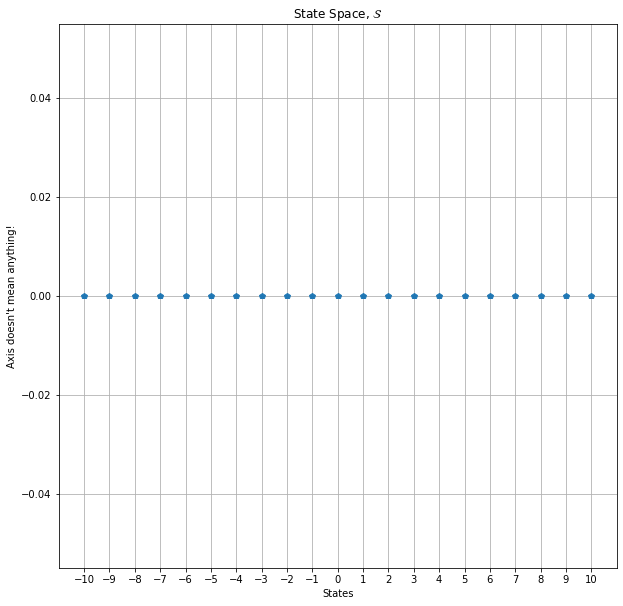

In [83]:
space = create_state_action_space(10)
print(space)

plt.figure(figsize=(10,10))
plt.plot(space, [0]*len(space), 'p')
plt.title('State Space, $\mathcal{S}$')
plt.xlabel('States')
plt.ylabel("Axis doesn't mean anything!")
_ = plt.xticks(space)
plt.grid()

We also need an action space. Well, let's pick it to have the same values (you'll see why) as the state space. Mathematically, the action space $\mathcal{A}$ is completely separate from the state space, $\mathcal{S}$ but in our case, we'll use the same function above to create the action space.

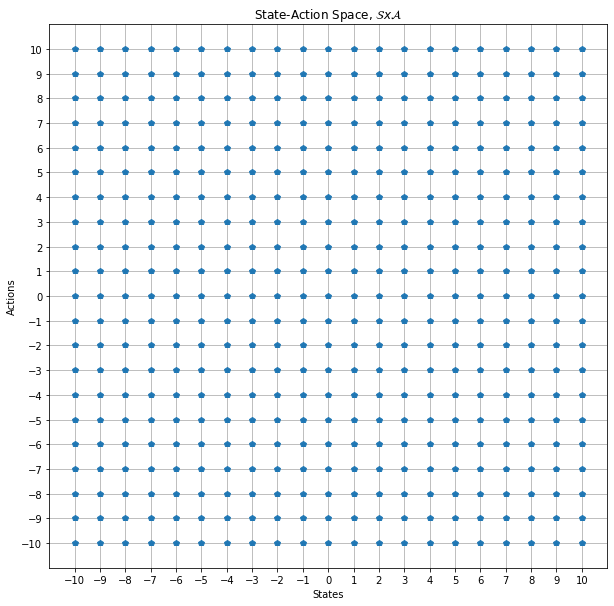

In [84]:
xes, yes = torch.meshgrid(space, space)

plt.figure(figsize=(10,10))
plt.plot(xes.flatten(), yes.flatten(), 'p')

plt.title('State-Action Space, $\mathcal{S} x \mathcal{A}$')
plt.xlabel('States')
plt.ylabel("Actions")

_ = plt.xticks(space)
_ = plt.yticks(space)
plt.grid()

Every point in the figure above denotes a **state-action** pair: $(s,a)$. The action space happens to look the same as the state space but that's generally not the case.

To define the environment and the task further, we need a **reward** function. In our case, this is a function of the state and action:

$$r(s,a)$$

We will define this as follows:

$$r(s,a) = -(s-a)^2$$

Your overwhelming question should be why this reward? Recall that we are trying to construct a toy example to try policy gradients. The state and action space were chosen to be the same. What this reward function says is that the immediate reward will be high when $s=a$ and decreases (becomes more negative) as $a$ differs more from $s$.

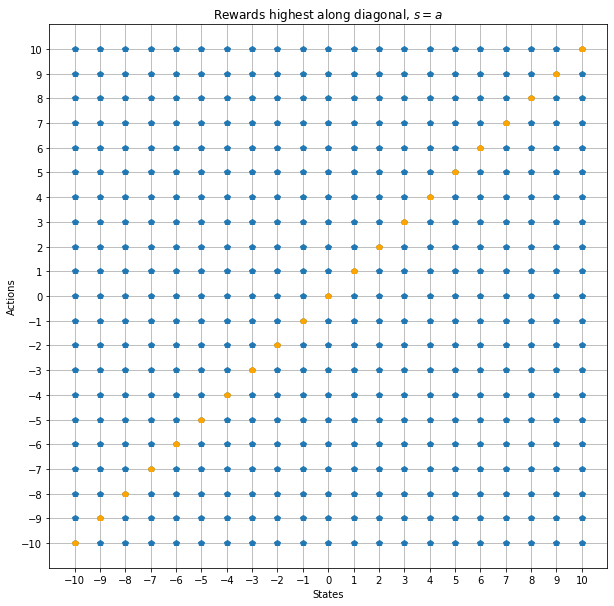

In [85]:
xes, yes = torch.meshgrid(space, space)

plt.figure(figsize=(10,10))
plt.plot(xes.flatten(), yes.flatten(), 'p')
plt.plot(space, space, 'p', color='orange')

plt.title('Rewards highest along diagonal, $s=a$')
plt.xlabel('States')
plt.ylabel("Actions")

_ = plt.xticks(space)
_ = plt.yticks(space)
plt.grid()

The only thing missing from our example is the dynamics which is defined below. The dynamics depends on the system under study. Since we are building an artificial system, we can choose any dynamics we like.

At time $t$, given the state $s_t$ and the chosen action $a_t$, we define the dynamics to be:

$$s_{t+1} = s_t + k a_t$$

where $k$ is some fixed step-size (=1 in all our experiments).

Since the states are restricted to a finite range $-L$ to $L$ (L=10 above), what happens if $s_t + ka_t > L$ or $s_t + ka_t < -L$ which are not valid states? In these cases, we use **periodic boundary conditions** where the states wrap around. In other words, the value $L+1$ (11) corresponds to $-L$ (-10).

In [86]:
def select_start_state(state_space):
    '''Choose a start state uniformly randomly from state space
    '''
    state = state_space[torch.multinomial(torch.ones(len(state_space)), 1)]

    return state

#some useful state parameters
N_space = len(space)
low_state = torch.min(space).unsqueeze(0).unsqueeze(0)
high_state = torch.max(space).unsqueeze(0).unsqueeze(0)

def dynamics(state, action, step_size, space):
    '''Simple dynamics
    '''
    if not isinstance(step_size, int) or step_size <= 0:
        raise ValueError("step_size should be a positive integer")

    #move left/right depending on action
    #space was chosen to have negative values so action could be both positive (right moves)
    #or negatives (left moves)
    
    #new_state = state + step_size*action
    new_state = state + step_size* ((torch.randint(0,2,(1,))-0.5)*2)[0]
    
    #hard boundary conditions - if hit boundary, stay there
    #if new_state > high_state:
    #    new_state = high_state
    #if new_state < low_state:
    #    new_state = low_state

    #periodic boundary conditions
    new_state = (new_state - low_state) % N_space + low_state
    
    return new_state

def reward(state, action):
    return -torch.pow((state - action), 2)

We also need to define our policy, $\pi(a_t|s_t)$. This can be any differentiable model but we'll choose a neural network here. N_inputs is the dimensionality of the state space and N_outputs is the number of distinct (discrete, in our case) actions.

In [87]:
class PolicyNet(nn.Module):
    def __init__(self, N_inputs, N_outputs, N_hidden_layers, N_hidden_nodes, activation, output_activation):
        super(PolicyNet, self).__init__()
        
        self.N_inputs = N_inputs
        self.N_outputs = N_outputs
        
        self.N_hidden_layers = N_hidden_layers
        self.N_hidden_nodes = N_hidden_nodes
        
        self.layer_list = nn.ModuleList([]) #use just as a python list
        for n in range(N_hidden_layers):
            if n==0:
                self.layer_list.append(nn.Linear(N_inputs, N_hidden_nodes))
            else:
                self.layer_list.append(nn.Linear(N_hidden_nodes, N_hidden_nodes))
        
        self.output_layer = nn.Linear(N_hidden_nodes, N_outputs)
        
        self.activation = activation
        self.output_activation = output_activation
        
    def forward(self, inp):
        out = inp
        for layer in self.layer_list:
            out = layer(out)
            out = self.activation(out)
            
        out = self.output_layer(out)
        if self.output_activation is not None:
            pred = self.output_activation(out)
        else:
            pred = out
        
        return pred

We are ready to start generating trajectories or paths! The process is very simple. We select a starting state (either deterministically or randomly), use our policy to generate a probability distribution on the actions, sample an action (either pick the one with maximum probability or sample according to the distribution), get an immediate reward and use the dynamics to jump to a new state. This process is repeated on the new state till some termination criterion. In our case, we run each trajectory for $T$ time-steps.

In [88]:
def create_trajectories(N, T, policy, step_size, space, debug=False):
    traj_action_probs = []
    traj_states = []
    traj_actions = []
    traj_rewards = []
    traj_total_rewards = []

    for i in range(N): #loop over trajectories
        
        #select initial state for trajectory
        state = select_start_state(space).unsqueeze(0)
        
        #needed quantities
        action_probs_list = [] #log probability of each action taken
        reward_list = [] #each immediate reward received
        state_list = [] #record each state
        action_list = [] #record each action
        total_reward = 0 #total reward

        if debug:
            print(f'Starting State: {state}')
        
        for t in range(T): #loop over time-steps within a trajectory
            
            #use policy to compute probability distribution on action space
            action_probs = policy(state).squeeze(0)
            
            assert((action_probs.sum().item()-1)**2 < 0.01)
            
            #select one of the actions according to the probability distribution
            action_selected_index = torch.multinomial(action_probs, 1) #index in action list
            action_selected_prob = action_probs[action_selected_index] #probability value
            action_selected = space[action_selected_index] #action selected (in our action space)
            
            if debug:
                print(f'---------Time step: {t}---------')
                print(f'Action probabilities: {action_probs}')
                print(f'Sum of Action probabilities: {action_probs.sum().item()}')
                print(f'Action selected index: {action_selected_index}')
                print(f'Action selected prob : {action_selected_prob}')
                print(f'Action selected      : {action_selected}')

            #record action prob (needed for computing gradients)
            action_probs_list.append(action_selected_prob)
            action_list.append(action_selected)
            
            #get immediate reward
            r = reward(state, action_selected).squeeze(0)
            reward_list.append(r)
            
            if debug:
                print(f'Reward for State {state} Action {action_selected}: {r}')

            #use dynamics to jump to next state
            state_list.append(state)
            state = dynamics(state, action_selected, step_size, space)
            
            if debug:
                print(f'New State: {state}')
            #add check: if state not in space

            #total reward received till now
            total_reward += r
            
            if debug:
                print(f'Total reward accumulated: {total_reward}')
                print('---------------\n')

        #get data for each trajectory
        traj_action_probs.append(action_probs_list)
        traj_rewards.append(reward_list)
        traj_actions.append(action_list)
        traj_states.append(state_list)
        traj_total_rewards.append(total_reward)

    return {
            'action_probs': traj_action_probs,
            'rewards': traj_rewards,
            'states': traj_states, 
            'actions': traj_actions,
            'total_rewards': traj_total_rewards
            }


To generate a trajectory, we need to initialize our policy:

In [89]:
#initialize policy

N_inputs = 1 #1 number for your current state since space is 1-dimensional
N_outputs = len(space) #probability for each action
N_hidden_layers = 1
N_hidden_nodes = 10
activation = nn.ReLU() #activation in hidden layers
output_activation = nn.Softmax(dim=1) #want probability distribution on action space

#technically, we should not use Sigmoid since we only care about log probs
#but don't worry about this now

policy = PolicyNet(N_inputs, 
                   N_outputs, 
                   N_hidden_layers, 
                   N_hidden_nodes,
                   activation,
                   output_activation=output_activation)

Let's generate 1 trajectory with 10 time-steps using our policy above. debug=True prints out details of each time-step:

In [90]:
data = create_trajectories(2, 10, policy, 1, space, debug=True)

Starting State: tensor([[5.]])
---------Time step: 0---------
Action probabilities: tensor([0.0236, 0.0679, 0.1295, 0.0341, 0.0144, 0.0635, 0.0460, 0.1247, 0.0736,
        0.1222, 0.0067, 0.0550, 0.0104, 0.0203, 0.0189, 0.0118, 0.0169, 0.0352,
        0.0512, 0.0508, 0.0232], grad_fn=<SqueezeBackward1>)
Sum of Action probabilities: 0.9999999403953552
Action selected index: tensor([1])
Action selected prob : tensor([0.0679], grad_fn=<IndexBackward>)
Action selected      : tensor([-9.])
Reward for State tensor([[5.]]) Action tensor([-9.]): tensor([-196.])
New State: tensor([[4.]])
Total reward accumulated: tensor([-196.])
---------------

---------Time step: 1---------
Action probabilities: tensor([0.0290, 0.0655, 0.1115, 0.0373, 0.0193, 0.0653, 0.0468, 0.1141, 0.0714,
        0.1009, 0.0098, 0.0601, 0.0137, 0.0248, 0.0217, 0.0156, 0.0210, 0.0403,
        0.0519, 0.0532, 0.0268], grad_fn=<SqueezeBackward1>)
Sum of Action probabilities: 0.9999998211860657
Action selected index: tensor([13

In [91]:
data

{'action_probs': [[tensor([0.0679], grad_fn=<IndexBackward>),
   tensor([0.0248], grad_fn=<IndexBackward>),
   tensor([0.0547], grad_fn=<IndexBackward>),
   tensor([0.0625], grad_fn=<IndexBackward>),
   tensor([0.0201], grad_fn=<IndexBackward>),
   tensor([0.0499], grad_fn=<IndexBackward>),
   tensor([0.0620], grad_fn=<IndexBackward>),
   tensor([0.0625], grad_fn=<IndexBackward>),
   tensor([0.0547], grad_fn=<IndexBackward>),
   tensor([0.0315], grad_fn=<IndexBackward>)],
  [tensor([0.0921], grad_fn=<IndexBackward>),
   tensor([0.0452], grad_fn=<IndexBackward>),
   tensor([0.0658], grad_fn=<IndexBackward>),
   tensor([0.0468], grad_fn=<IndexBackward>),
   tensor([0.1141], grad_fn=<IndexBackward>),
   tensor([0.0679], grad_fn=<IndexBackward>),
   tensor([0.1009], grad_fn=<IndexBackward>),
   tensor([0.0512], grad_fn=<IndexBackward>),
   tensor([0.1340], grad_fn=<IndexBackward>),
   tensor([0.1661], grad_fn=<IndexBackward>)]],
 'rewards': [[tensor([-196.]),
   tensor([-1.]),
   tensor([-

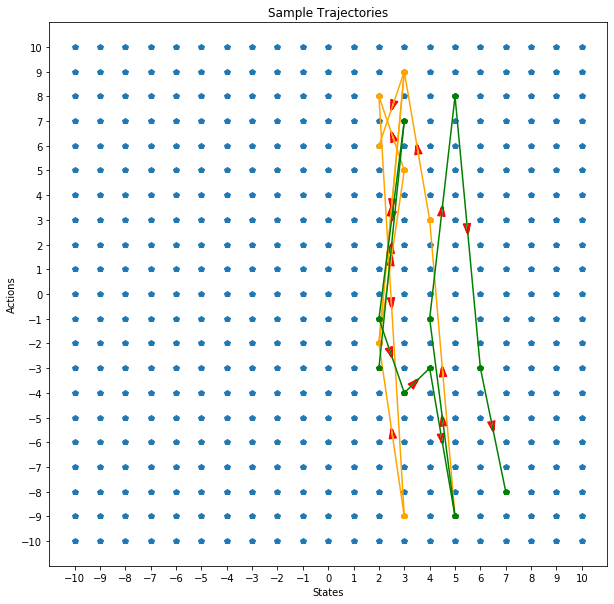

In [92]:
def plot_trajectory(space, traj_data, idx, color='orange', new_figure=True):
    states = traj_data['states'][idx]
    actions = traj_data['actions'][idx]

    xes, yes = torch.meshgrid(space, space)

    if new_figure:
        plt.figure(figsize=(10,10))
        plt.plot(xes.flatten(), yes.flatten(), 'p')

    for i in range(1, len(states)):
        prev_point = (states[i-1], actions[i-1])
        curr_point = (states[i], actions[i])
        grad = [curr_point[0]-prev_point[0], curr_point[1]-prev_point[1]]
        grad = grad / np.sqrt(np.sum(np.power(grad, 2)))
        scale_factor = 0.1
        
        plt.plot([prev_point[0], curr_point[0]], [prev_point[1], curr_point[1]], 'p-', color=color)
        plt.arrow(0.5*(prev_point[0] + curr_point[0]), 
                  0.5*(prev_point[1] + curr_point[1]), 
                  scale_factor*grad[0],
                  scale_factor*grad[1],
                  width=0.1,          
                  shape='full', 
                  length_includes_head=True,
                  color='red')
        
    plt.title('Sample Trajectories')
    plt.xlabel('States')
    plt.ylabel("Actions")

    _ = plt.xticks(space)
    _ = plt.yticks(space)
    plt.grid()

plot_trajectory(space, data, 0)
plot_trajectory(space, data, 1, color='green', new_figure=False)

## Implementing policy gradients

### Base Implementation

In [94]:
def select_start_state(state_space, N=1):
    '''Choose a start state uniformly randomly from state space
    '''
    state = state_space[torch.multinomial(torch.ones(N, len(state_space)), 1)]

    if N==1:
        state = state.squeeze(1)
    
    return state

print("Example: \n", select_start_state(space, N=1))
print("Example: \n", select_start_state(space, N=2))

Example: 
 tensor([2.])
Example: 
 tensor([[ 4.],
        [-1.]])


In [96]:
def create_trajectories_optimized(N, T, policy, step_size, space, debug=False):
    '''Optimize trajectory generation
    states, actions, action probabilities, rewards intialized as matrices
    one row per trajectory, one column per time-step
    generate one column at a time across all trajectories
    '''
    
    #matrices holding states, actions, action probabilities, rewards
    mat_states = torch.zeros(N, T, 1)
    mat_actions = torch.zeros_like(mat_states)
    mat_action_probs = torch.zeros_like(mat_states)
    mat_rewards = torch.zeros_like(mat_states)

    #initialize start state
    mat_states[:,0] = select_start_state(space, N=N)

    for t in range(T): #loop over time-steps
        action_probs = policy(mat_states[:,t])
        action_selected_index = torch.multinomial(action_probs, 1)

        mat_action_probs[:,t] = action_probs.gather(1, action_selected_index)
        mat_actions[:,t] = space[action_selected_index]

        if t < T-1: #don't store state for actions taken at time-step T-1 (last time-step)
            mat_states[:,t+1] = dynamics(mat_states[:,t], mat_actions[:,t], 1, space)
    
    #compute reward at end given states and actions
    mat_rewards = reward(mat_states, mat_actions)
    mat_total_rewards = mat_rewards.sum(dim=1)
    
    return {
        'action_probs': mat_action_probs,
        'rewards': mat_rewards,
        'states': mat_states, 
        'actions': mat_actions,
        'total_rewards': mat_total_rewards
        }

In [97]:
%time data = create_trajectories_optimized(100, 10, policy, 1, space)

CPU times: user 18 ms, sys: 997 µs, total: 19 ms
Wall time: 10.1 ms


In [98]:
%time data = create_trajectories(100, 10, policy, 1, space)

CPU times: user 242 ms, sys: 2.01 ms, total: 244 ms
Wall time: 243 ms


In [99]:
%timeit data = create_trajectories_optimized(100, 10, policy, 1, space)

2.78 ms ± 63.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [100]:
%timeit data = create_trajectories(100, 10, policy, 1, space)

228 ms ± 3.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [101]:
data_optimized = create_trajectories_optimized(100, 10, policy, 1, space)

**Future Question**: For the optimized function, why is the result from timeit so much lower than from time? Some caching?

We have an (artificial) environment with a state space, dynamics, action space, reward function and even an untrained machine learning model for a policy.

How do we train this policy? If this was a supervised problem, it would be easy. Take your data:

(input, label) = $(\vec{x}_i, y_i)$ for $i=1, \ldots, N$

Use your model, $p_{\theta}(\vec{x})$ to make predictions, compute a loss/cost that compares your prediction to the label and tune $\theta$ to minimze the loss. To be more concrete, suppose we have a multi-class classification problem i.e. $y_i \in \{1, \ldots, k\}$ and the loss is cross-entropy:

$$\mathcal{L_i} = -\Sigma_{j=1}^{k} y_{ij} \log p_{ij}(\vec{x_i})$$

$y_{ij} = 1$ if the ith example has label $j$ and 0 otherwise (it's the one-hot encoded label vector). Similarly, $p_{ij}$ is the probability that the ith example has label $j$. By definition, $\Sigma_{j=1}^{k} p_{ij} = 1$.

To be clear, the sum over the classes always gives only one term. Since $y_{ij}=1$ for exactly one $j$ (the label), the loss reduces to:

$$\mathcal{L_i} = -y_{il} \log p_{il}(\vec{x_i}) = -\log p_{il}(\vec{x_i})$$

where $l$ is the true label for the ith example. If the predicted probability is 1, i.e. the model predicted the correct label with full probability, then the loss is 0 ($\log 1 = 0$). On the other end, theoretically, if the model predicted the probability of the true label to be 0, then the loss is $\infty$ ($\log 0 = -\infty$). So we evaluate each example on the basic of the predicted probability of the true label. (This is also equivalent to maximum likelihood under a multinomial distribution).

The total loss would just be the loss summed across all the training examples:

$$\mathcal{L} = \Sigma_{i=1}^{n} \mathcal{L}_i = -\Sigma_{i=1}^n \Sigma_{j=1}^{k} y_{ij}\log p_{ij}(\vec{x}_i)$$

We can then update $\theta$ by doing gradient descent as usual:

$$\theta^{(t+1)} = \theta^{(t)} - \eta \nabla_{\theta} \mathcal{L}$$

If one is working with neural networks (which we will do exclusively in this notebook), the gradients can be computed using backpropagation. Auto-differentiation ("autodiff") libraries like PyTorch and TensorFlow make this easy for us. In pseudo-code, we would have something like:

#given features and labels

predictions = model(features)

loss = loss_function(predictions, labels)

loss.backward() #compute gradient

update_parameters() #implements the gradient descent step

But all this is possible because the thing we are minimizing (the loss) is "directly connected to" the parameters, $\theta$. What this means is that the loss is a differentiable function of $\theta$ through the predictions $p_\theta$. This is not the case in reinforcement learning! The thing we want to maximize (the total reward, $R$) is not a differentiable function of the parameters of the policy, $\theta$. The reward is something we receive from the environment. We have no way of even connecting the immediate reward at time-step t, $r_t$ to the policy except to know a loose correspondence that $r_t$ is somehow a consequence of all the steps taken till time t. So, how do we go about connecting changes in $R$ to changes in the policy, $\theta$?

It helps to stare at the quantity we are maximizing, the expected reward:

$$J(\theta) = \mathbb{E}_{\tau} \left(\Sigma_{t=1}^{T} r_t\right) \left(\Sigma_{t=1}^{T} \log \pi(a_t|s_t)\right) = \mathbb{E}_{\tau} R(\tau) \left(\Sigma_{t=1}^{T} \log \pi(a_t|s_t)\right)$$

If it helps, think of the sample estimate from $n$ trajectories:

$$J(\theta) \approx \frac{1}{n}\Sigma_{i=1}^{n} R(\tau^{(i)}) \left(\Sigma_{t=1}^{T} \log \pi(a_t^{(i)}|s_t^{(i)})\right)$$

I'll be pedantic here for the sake of clarity:

$$J(\theta) \approx \frac{1}{n}\Sigma_{i=1}^{n} R(\tau^{(i)}) \left(\log \pi(a_1^{(i)}|s_1^{(i)}) + \log \pi(a_2^{(i)}|s_2^{(i)}) + \ldots + \log \pi(a_T^{(i)}|s_T^{(i)})\right)$$

We can pass through the $R(\tau^{(i)})$ term through the sum to get:

$$J(\theta) \approx \frac{1}{n}\Sigma_{i=1}^{n} \Sigma_{t=1}^{T} R(\tau^{(i)})  \log \pi(a_t^{(i)}|s_t^{(i)})$$

Compare this to the loss from the binary classification problem:

$$\mathcal{L} = \Sigma_{i=1}^{n} \mathcal{L}_i = -\Sigma_{i=1}^n \Sigma_{j=1}^{k} y_{ij}\log p_{ij}(\vec{x}_i) = -\Sigma_{i=1}^n y_{il}\log p_{il}(\vec{x}_i) = -\Sigma_{i=1}^n \log p_{il}(\vec{x}_i)$$

where we collapse the second sum over the k classes by choosing the correct label class $l$ and also use $y_{il}=1$ by definition.

The overall factor of $\frac{1}{n}$ doesn't matter. Maximizing $J(\theta)$ is equivalent to maximizing C$ J(\theta)$ where C is a positive constant. Also, maximizing $J(\theta)$ is equivalent to minimizing $-J(\theta)$. So, we are minimizing:

$$-J(\theta) \approx -\Sigma_{i=1}^{n} \Sigma_{t=1}^{T} R(\tau^{(i)})  \log \pi(a_t^{(i)}|s_t^{(i)})$$

What about the double-sum $\Sigma_i\Sigma_t$? Well, that's just saying that we are have $nT$ examples or data-points vs $n$ in the binary clasification problem? That's not crucial to our argument. So we are really just comparing the following two quantities:

Binary classification:

$$\log p_{il}(y|\vec{x}_i)$$ 

Policy Gradient:

$$R(\tau^{(i)})  \log \pi(a_t^{(i)}|s_t^{(i)})$$

For binary classification, we make it explicit that we are predicting a probability distribution on $y_i$ (the k labels) given the features, $\vec{x}_i$ just like for policy gradient, the policy/model predicts the probability distribution on the actions $a_t$ given the current state $s_t$.

Let's summarize what we have learned till this point. For multi-class classification, we define the loss for an example to be the (negative) log of the probability that the model predicted for the correct label. There is a clear notion of what the correct label is. Maximizing this probability of predicting the label would lead to a lower loss.

For policy gradients, we can treat each action in each trajectory as an independent data point. **We don't know what action is the "correct" action to take at any point in time.** So we declare that the action we took is the correct one! Mechanically this means that we now care about the (negative) log of the predicted probability of taking the action we actually performed. In the case of multiclass classification, we wanted to increase this probability by tuning the model's parameters. In the policy gradient case, we still aim to increase this probability but we weigh each log probability contribution by the total reward received for the trajectory that it was a part of. So increasing the probability of taking an action given a state by a fixed amount $\epsilon$ will count for far more if the action was taken in a high-reward trajectory than if it was taken for a low reward trajectory.

Furthermore, this equivalence between multi-class supervised learning and policy gradients has some convenient side-effects. We can simulate or run $n$ trajectories using our current policy (with possibly very sub-optimal parameters, $\theta$), collect the list of probabilities, $\pi(a_t|s_t)$, weight each one by the total reward of the trajectory (gotten after the end of the trajectory) and then define a loss that looks very similar to multi-class cross-entropy except that each $\pi(a_t|s_t)$ term has a weight equal to the total reward in its trajectory. At this stage, we can use all the power of our auto-diff library to pretend we have a classification problem and optimize $J(\theta)$.

Weighing by $R(\tau)$ is also intuitively satisfying: we should maximize the probability of actions taken during high-reward trajectories and minimize the probability of actions taken during low-reward trajectories.

Let's see this fitting procedure in action. We are not focusing on code efficiency for now. Recall our starting point is the data from the trajectory:

In [103]:
data

{'action_probs': [[tensor([0.0718], grad_fn=<IndexBackward>),
   tensor([0.0095], grad_fn=<IndexBackward>),
   tensor([0.0213], grad_fn=<IndexBackward>),
   tensor([0.0593], grad_fn=<IndexBackward>),
   tensor([0.3902], grad_fn=<IndexBackward>),
   tensor([0.2388], grad_fn=<IndexBackward>),
   tensor([0.0068], grad_fn=<IndexBackward>),
   tensor([0.0645], grad_fn=<IndexBackward>),
   tensor([0.0680], grad_fn=<IndexBackward>),
   tensor([0.2388], grad_fn=<IndexBackward>)],
  [tensor([0.1933], grad_fn=<IndexBackward>),
   tensor([0.2361], grad_fn=<IndexBackward>),
   tensor([0.0277], grad_fn=<IndexBackward>),
   tensor([0.2361], grad_fn=<IndexBackward>),
   tensor([0.0353], grad_fn=<IndexBackward>),
   tensor([0.0630], grad_fn=<IndexBackward>),
   tensor([0.0370], grad_fn=<IndexBackward>),
   tensor([0.0533], grad_fn=<IndexBackward>),
   tensor([0.3563], grad_fn=<IndexBackward>),
   tensor([0.3902], grad_fn=<IndexBackward>)],
  [tensor([0.0453], grad_fn=<IndexBackward>),
   tensor([0.318

In [104]:
def expected_reward(s, debug=False):
    #TODO: use torch tensor operations
    action_probs = s['action_probs'] #action probabilities for each action at each time-step
    total_rewards = s['total_rewards'] #total reward for each trajectory

    total = 0
    for idx, traj_reward in enumerate(total_rewards): #loop over every trajectory
        traj_action_probs = s['action_probs'][idx] #get action probabilities at each time-step

        if debug:
            print(traj_reward)
            print(traj_action_probs)

        #naive computation of J
        sum_log_prob = torch.cat(traj_action_probs).log().sum() #sum of log probabilities for actions
        total += sum_log_prob * traj_reward #J = (total reward)*(sum of log probs)

    return total / len(total_rewards)

All we are doing in the above function is computing:

$$J \approx \frac{1}{n} \Sigma_{i=1}^{n} R(\tau^{(i)}) \Sigma_{t=1}^T \log \pi(a_t^{(i)}|s_t^{(i)})$$

We need to maximize this quantity or equivalently, minimize $-J$.

In [105]:
def optimize(optimizer, exp_reward, lr=1e-2):
    optimizer.zero_grad()
    (-exp_reward).backward() #doing gradient **ascent** - computes gradients
    optimizer.step() #carries out gradient ascent update

We can now put this all together in the following sequence:

1. Generate $n$ trajectories

2. Compute $J$ from these trajectories

3. Do gradient ascent i.e. tune the policy's weights $\theta$ to increase $J$

4. Repeat

In [106]:
def training_loop(N_iter, 
                  batch_size, 
                  T, 
                  space, 
                  policy=None, 
                  lr=1e-2, 
                  step_size=1, 
                  debug=False):
    
    if policy is None:
        policy = PolicyNet(1, len(space), 1, 10, nn.ReLU(), nn.Softmax(dim=1))
    
    optimizer = optim.Adam(policy.parameters(), lr=lr) #don't worry about this - variant of gradient descent

    exp_reward_list = []

    for i in range(N_iter): #N_iterations
    
        #step 1: generate batch_size trajectories
        s = create_trajectories(batch_size, T, policy, step_size, space, debug=debug)
    
        #step 2: define J
        exp_reward = expected_reward(s, debug=debug)
        exp_reward_list.append(exp_reward)

        #step 3: do gradient ascent
        optimize(optimizer, exp_reward, lr=lr)

        if i % 1000 == 0:
            #Empirical Reward = mean of the total rewards for trajectories just generated
            #Expected Reward = Mean(R(tau) * log P(tau)) which is NOT J but used to calculate gradients 
            print(f'Iter {i}: Expected Reward = {exp_reward} Empirical Reward = {np.mean(s["total_rewards"])}')

    return policy, exp_reward_list

In [107]:
#initialize policy
N_inputs = 1 #1 number for your current state since space is 1-dimensional
N_outputs = len(space) #probability for each action
N_hidden_layers = 1
N_hidden_nodes = 10
activation = nn.ReLU() #activation in hidden layers
output_activation = nn.Softmax(dim=1) #want probability distribution on action space
#technically, we should not use Sigmoid since we only care about log probs
#but don't worry about this now

policy = PolicyNet(N_inputs, 
                   N_outputs, 
                   N_hidden_layers, 
                   N_hidden_nodes,
                   activation,
                   output_activation=output_activation)

N_iter = 10000
batch_size = 10
T = 10

policy, exp_reward_list = training_loop(N_iter, 
                                        batch_size, 
                                        T, 
                                        space, 
                                        policy=policy, 
                                        lr=1e-2, 
                                        step_size=1)

Iter 0: Expected Reward = tensor([26716.0996], grad_fn=<DivBackward0>) Empirical Reward = -1143.699951171875
Iter 1000: Expected Reward = tensor([362.8427], grad_fn=<DivBackward0>) Empirical Reward = -85.5999984741211
Iter 2000: Expected Reward = tensor([45.2502], grad_fn=<DivBackward0>) Empirical Reward = -71.80000305175781
Iter 3000: Expected Reward = tensor([17.9998], grad_fn=<DivBackward0>) Empirical Reward = -41.900001525878906
Iter 4000: Expected Reward = tensor([7.7079], grad_fn=<DivBackward0>) Empirical Reward = -75.4000015258789
Iter 5000: Expected Reward = tensor([12.0423], grad_fn=<DivBackward0>) Empirical Reward = -80.80000305175781
Iter 6000: Expected Reward = tensor([22.2842], grad_fn=<DivBackward0>) Empirical Reward = -46.5
Iter 7000: Expected Reward = tensor([1.3649], grad_fn=<DivBackward0>) Empirical Reward = -68.9000015258789
Iter 8000: Expected Reward = tensor([2.2986], grad_fn=<DivBackward0>) Empirical Reward = -50.70000076293945
Iter 9000: Expected Reward = tensor(

ADD NOTE THAT THIS IS NOT ACTUALLY J

Let's understand what the above output signifies. The function runs N_iter iterations of the training loop. During each iteration, batch_size trajectories are generated using the current policy. Each trajectory has T time-steps. For each trajectory, at each time-step, the probability for taking the action that was taken is recorded. The total reward for each trajectory is also rewarded. Given these two quantities, we compute the total $"J" = \frac{1}{n}\Sigma_{i}=1^{n} \left(\Sigma_{t=1}^T \log \pi(a_t^{(i)}|s_t^{(i)}) \right)\left(R(\tau^{(i)})\right)$ and then do back-propagation to calculate the gradients. These gradients are used to update the policy weights to **increase** $"J"$ (gradient ascent instead of descent).

ADD NOTE ABOUT EXPECTED REWARD

CLEAN UP

Note that:

1. For each iteration, the average reward across batch_size trajectories is printed (Empirical Reward). The reward rapidly increases (becomes less negative) and ideally we would get 0 empirical reward i.e. at each time-step, the action picked was exactly equal to the state for our environment.

2. For each iteration, we generate batch_size trajectories. Not only that, we never use the trajectories generated in previous iterations for the current iteration. In other words, we throw away all the data (which is generated sequentially on a CPU not the GPU). This is very different from supervised learning where we have a static dataset that stays constant. Is this justified? Can't we just keep a growing data-structure that has all the data generated till time t? The answer is no! Recall that when training supervised models, we make the assumption that the distribution that the training data is generated from is the same as the one the test data or new data that will be encountered is generated from. In the RL case, each time the policy changes, the distribution of actions taken and states visited is changed which means the training data at the current iteration is drawn from a different distribution from the training data in past iterations and they can be bundled together. This leads to the question of whether we can do some modifications or corrections to data from past iterations and will lead us to the notion of **importance sampling** (but later). 

Since the policy maps a state to an action and we know what the ideal action should be (ideal action = state for our environment), let's look at the policies outputs. To be more precise, the policy predicts a probability distribution over all possible actions for a given state. Below, for each state, we plot the action with the **highest** probability.

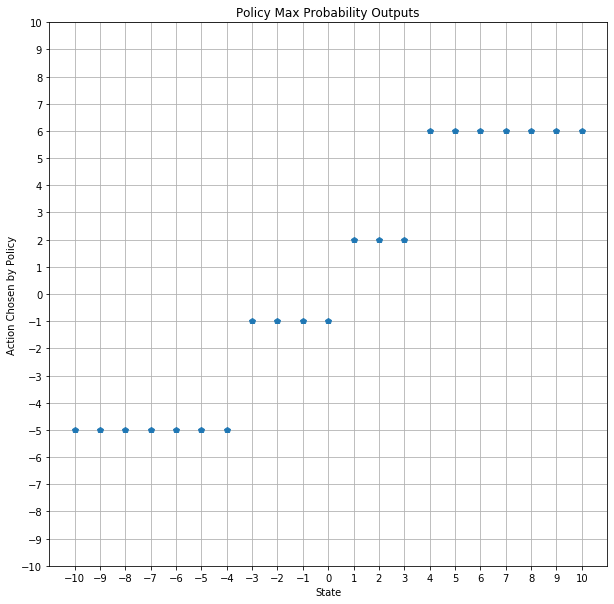

In [109]:
plt.figure(figsize=(10,10))
plt.plot(space, space[policy(space.unsqueeze(1)).argmax(dim=1)], 'p')
plt.xlabel("State")
plt.ylabel("Action Chosen by Policy")
plt.title("Policy Max Probability Outputs")
_ = plt.xticks(space)
_ = plt.yticks(space)
plt.grid()

We do see a strong correlation between the state and action which is great news! In the ideal case, the policy would realize that choosing the action to be equal to the state maximizes the reward. It comes close but has a hard-time "resolving the reward structure at a finer level". For example, the policy always picks the action 2 when the state varies from -1 to +4. It realizes that beyond this state, the action must be increased but can't figure out these it can increase the expected reward by choosing different actions within this range.

We can already anticipate a potential problem. Suppose, our initial policy is very confident but wrong (unfortunately, a widespread phenomenon among humans today) about the actions it must take in every state. Then, as we generate different trajectories, we will never find out, for example, that taking the confident action +4 in state 0 is far worse than the action +1 in state 0. Since we will never try out action +1 in state 0, we will never learn and improve on what we know. This is the problem of **exploration** i.e. taking a risk and trying something different from what you (the policy) knows in the hope of finding a better action or outcome.

The big question now is: How do we improve this?!

### Code Optimization

Before we go to improve the algorithm itself, let's optimize the code so we can do experiments faster. While it might be obvious that we spend most of our time in creating the trajectories, let's confirm this (only adding the decorator @profile below):

In [29]:
@profile(immediate=True)
def training_loop(N_iter, 
                  batch_size, 
                  T, 
                  space, 
                  policy=None, 
                  lr=1e-2, 
                  step_size=1, 
                  debug=False):
    
    if policy is None:
        policy = PolicyNet(1, len(space), 1, 10, nn.ReLU(), nn.Softmax(dim=1))
    
    optimizer = optim.Adam(policy.parameters(), lr=lr) #don't worry about this - variant of gradient descent

    exp_reward_list = []

    for i in range(N_iter): #N_iterations
    
        #step 1: generate batch_size trajectories
        s = create_trajectories(batch_size, T, policy, step_size, space, debug=debug)
    
        #step 2: define J
        exp_reward = expected_reward(s, debug=debug)
        exp_reward_list.append(exp_reward)

        #step 3: do gradient ascent
        optimize(optimizer, exp_reward, lr=lr)

        if i % 1000 == 0:
            #Empirical Reward = mean of the total rewards for trajectories just generated
            #Expected Reward = Mean(R(tau) * log P(tau)) which is NOT J but used to calculate gradients 
            print(f'Iter {i}: Expected Reward = {exp_reward} Empirical Reward = {np.mean(s["total_rewards"])}')

    return policy, exp_reward_list

In [ ]:
#NO CHANGES HERE EXCEPT N_iter = 1000 (instead of 10,000)

#initialize policy
N_inputs = 1 #1 number for your current state since space is 1-dimensional
N_outputs = len(space) #probability for each action
N_hidden_layers = 1
N_hidden_nodes = 10
activation = nn.ReLU() #activation in hidden layers
output_activation = nn.Softmax(dim=1) #want probability distribution on action space
#technically, we should not use Sigmoid since we only care about log probs
#but don't worry about this now

policy = PolicyNet(N_inputs, 
                   N_outputs, 
                   N_hidden_layers, 
                   N_hidden_nodes,
                   activation,
                   output_activation=output_activation)

N_iter = 1000
batch_size = 10
T = 10

policy, exp_reward_list = training_loop(N_iter, 
                                        batch_size, 
                                        T, 
                                        space, 
                                        policy=policy, 
                                        lr=1e-2, 
                                        step_size=1)

At least on my machine, ~67% (20s/30s) of the total runtime is spent in create_trajectories. This is reasonable since we have a basic implementation consisting of double for-loops. Can we optimize this?

Since all our trajectories have the same time-length (T), and since we can use the faster SIMD implementations of torch functions (to execute the policy and to generate random numbers), we should use matrices of size N (number of trajectories) x T (number of time-steps) to store the states, actions, probabilities of actions and rewards. The columns (each time-step) will be populated simultaneously.

One optimized implementation is below:

In [47]:
def create_trajectories_optimized(N, T, policy, step_size, space, debug=False):
    mat_states = torch.zeros(N, T, 1)
    mat_actions = torch.zeros_like(mat_states)
    mat_action_probs = torch.zeros_like(mat_states)
    mat_rewards = torch.zeros_like(mat_states)

    #initialize start state
    mat_states[:,0] = select_start_state(space, N=N)

    for t in range(T): #loop over time-steps
        action_probs = policy(mat_states[:,t].clone())
        action_selected_index = torch.multinomial(action_probs, 1)

        mat_action_probs[:,t] = action_probs.gather(1, action_selected_index)
        mat_actions[:,t] = space[action_selected_index]

        if t < T-1: #don't store state for actions taken at time-step T-1 (last time-step)
            mat_states[:,t+1] = dynamics(mat_states[:,t], mat_actions[:,t], 1, space)
    
    #compute reward at end given states and actions
    mat_rewards = reward(mat_states, mat_actions)
    mat_total_rewards = mat_rewards.sum(dim=1)
    
    return {
        'action_probs': mat_action_probs,
        'rewards': mat_rewards,
        'states': mat_states, 
        'actions': mat_actions,
        'total_rewards': mat_total_rewards
        }

In [46]:
%time data = create_trajectories_optimized(100, 10, policy, 1, space)

CPU times: user 5.49 ms, sys: 949 µs, total: 6.44 ms
Wall time: 3.48 ms


In [39]:
%time data = create_trajectories(100, 10, policy, 1, space)

CPU times: user 179 ms, sys: 2.98 ms, total: 182 ms
Wall time: 182 ms


In [36]:
%timeit data = create_trajectories_optimized(100, 10, policy, 1, space)

2.24 ms ± 21.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
%timeit data = create_trajectories(100, 10, policy, 1, space)

163 ms ± 864 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Future Question**: For the optimized function, why is the result from timeit so much lower than from time? Some caching?

Check: check if the functions result in the same trajectories if seeds are fixed

In [ ]:
torch.manual_seed(10)
data_optimized = create_trajectories_optimized(1, 10, policy, 1, space)

In [ ]:
torch.manual_seed(10)
data = create_trajectories(1, 10, policy, 1, space)

In [ ]:
print(data['states'])
print("\n")
print(data_optimized['states'])

In [ ]:
print(data['actions'])
print("\n")
print(data_optimized['actions'])

In [ ]:
print(data['action_probs'])
print("\n")
print(data_optimized['action_probs'])

Let's change training_loop so it just the optimized function. We will also need

In [ ]:
data['states']

In [ ]:
data_optimized['states']

In [ ]:
torch.manual_seed(15)
data = create_trajectories(3, 10, policy, 1, space)
exp_reward = expected_reward(data, debug=True)
print(exp_reward)

In [ ]:
data['total_rewards']

In [ ]:
data_optimized['total_rewards']

In [ ]:
torch.manual_seed(15)
data_optimized = create_trajectories_optimized(3, 10, policy, 1, space)
exp_reward = expected_reward_optimized(data_optimized)
print(exp_reward)

In [ ]:
torch.autograd.set_detect_anomaly(True)

In [ ]:
exp_reward.backward()

In [49]:
#CHANGE create_trajectories -> create_trajectories_optimized
#CHANGE expected_reward -> expected_reward_optimized

def expected_reward(s, debug=False):
    #TODO: use torch tensor operations
    action_probs = s['action_probs'] #action probabilities for each action at each time-step
    total_rewards = s['total_rewards'] #total reward for each trajectory

    total = 0
    for idx, traj_reward in enumerate(total_rewards): #loop over every trajectory
        traj_action_probs = s['action_probs'][idx] #get action probabilities at each time-step

        #if debug:
        #    print(traj_reward)
        #    print(traj_action_probs)

        #naive computation of J
        sum_log_prob = torch.cat(traj_action_probs).log().sum() #sum of log probabilities for actions
        if debug:
            print(sum_log_prob)
        total += sum_log_prob * traj_reward #J = (total reward)*(sum of log probs)

    return total / len(total_rewards)

def expected_reward_optimized(s, debug=False):
    return (s['action_probs'].log().sum(dim=1) * s['total_rewards']).mean()

@profile(immediate=True)
def training_loop_optimized(N_iter, 
                  batch_size, 
                  T, 
                  space, 
                  policy=None, 
                  lr=1e-2, 
                  step_size=1, 
                  debug=False):
    
    if policy is None:
        policy = PolicyNet(1, len(space), 1, 10, nn.ReLU(), nn.Softmax(dim=1))
    
    optimizer = optim.Adam(policy.parameters(), lr=lr) #don't worry about this - variant of gradient descent

    exp_reward_list = []

    for i in range(N_iter): #N_iterations
    
        #step 1: generate batch_size trajectories
        s = create_trajectories_optimized(batch_size, T, policy, step_size, space, debug=debug)
    
        #step 2: define J
        exp_reward = expected_reward_optimized(s, debug=debug)
        exp_reward_list.append(exp_reward)

        #step 3: do gradient ascent
        optimize(optimizer, exp_reward, lr=lr)

        if i % 1000 == 0:
            #Empirical Reward = mean of the total rewards for trajectories just generated
            #Expected Reward = Mean(R(tau) * log P(tau)) which is NOT J but used to calculate gradients 
            print(f'Iter {i}: Expected Reward = {exp_reward} Empirical Reward = {np.mean(s["total_rewards"].numpy())}')

    return policy, exp_reward_list

In [54]:
import gc
gc.collect()

6288

In [53]:
del policy

In [80]:
#NO CHANGES HERE EXCEPT N_iter = 1000 (instead of 10,000)

#initialize policy
N_inputs = 1 #1 number for your current state since space is 1-dimensional
N_outputs = len(space) #probability for each action
N_hidden_layers = 1
N_hidden_nodes = 10
activation = nn.ReLU() #activation in hidden layers
output_activation = nn.Softmax(dim=1) #want probability distribution on action space
#technically, we should not use Sigmoid since we only care about log probs
#but don't worry about this now

policy = PolicyNet(N_inputs, 
                   N_outputs, 
                   N_hidden_layers, 
                   N_hidden_nodes,
                   activation,
                   output_activation=output_activation)

N_iter = 20000
batch_size = 100
T = 30

policy, exp_reward_list = training_loop_optimized(N_iter, 
                                                  batch_size, 
                                                  T, 
                                                  space, 
                                                  policy=policy, 
                                                  lr=1e-3, 
                                                  step_size=1)

Iter 0: Expected Reward = 149245.8125 Empirical Reward = -1918.1500244140625
Iter 1000: Expected Reward = 10442.693359375 Empirical Reward = -337.0899963378906
Iter 2000: Expected Reward = 4991.92333984375 Empirical Reward = -289.0400085449219
Iter 3000: Expected Reward = 3458.007080078125 Empirical Reward = -247.0500030517578
Iter 4000: Expected Reward = 1934.3843994140625 Empirical Reward = -195.92999267578125
Iter 5000: Expected Reward = 1198.9412841796875 Empirical Reward = -216.4499969482422
Iter 6000: Expected Reward = 1315.51904296875 Empirical Reward = -204.0500030517578
Iter 7000: Expected Reward = 954.0064086914062 Empirical Reward = -162.8300018310547
Iter 8000: Expected Reward = 1217.58544921875 Empirical Reward = -185.9199981689453
Iter 9000: Expected Reward = 368.3169250488281 Empirical Reward = -160.80999755859375
Iter 10000: Expected Reward = 241.18605041503906 Empirical Reward = -202.02000427246094
Iter 11000: Expected Reward = 487.91796875 Empirical Reward = -186.6199

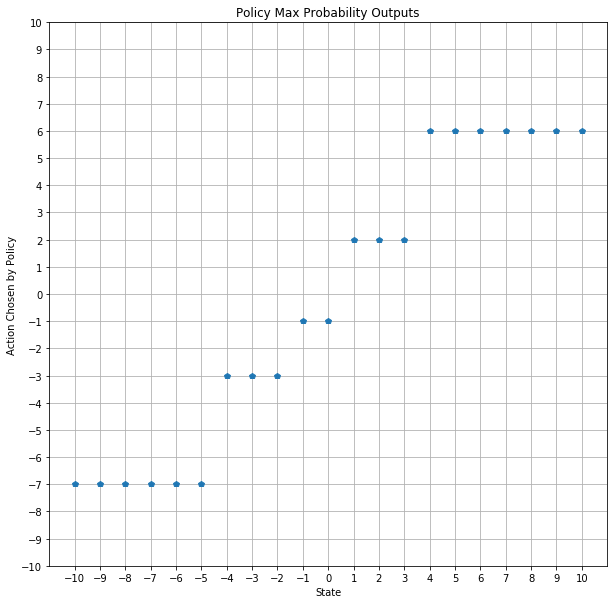

In [67]:
plt.figure(figsize=(10,10))
plt.plot(space, space[policy(space.unsqueeze(1)).argmax(dim=1)], 'p')
plt.xlabel("State")
plt.ylabel("Action Chosen by Policy")
plt.title("Policy Max Probability Outputs")
_ = plt.xticks(space)
_ = plt.yticks(space)
plt.grid()

### Causality

In [78]:
data_optimized = create_trajectories_optimized(1, 30, policy, 1, space)

In [79]:
data_optimized['actions']

tensor([[[7.],
         [7.],
         [7.],
         [7.],
         [7.],
         [7.],
         [7.],
         [7.],
         [7.],
         [7.],
         [7.],
         [7.],
         [7.],
         [7.],
         [4.],
         [7.],
         [7.],
         [7.],
         [7.],
         [7.],
         [7.],
         [7.],
         [7.],
         [7.],
         [7.],
         [4.],
         [7.],
         [7.],
         [7.],
         [7.]]])

In [70]:
data_optimized['states']

tensor([[[ -6.],
         [ -7.],
         [ -8.],
         [ -7.],
         [ -6.],
         [ -5.],
         [ -6.],
         [ -7.],
         [ -6.],
         [ -7.],
         [ -8.],
         [ -9.],
         [ -8.],
         [ -7.],
         [ -6.],
         [ -7.],
         [ -8.],
         [ -7.],
         [ -8.],
         [ -7.],
         [ -6.],
         [ -7.],
         [ -6.],
         [ -7.],
         [ -8.],
         [ -9.],
         [-10.],
         [ -9.],
         [-10.],
         [ 10.]]])

In [72]:
data_optimized['rewards']

tensor([[[ -1.],
         [ -0.],
         [ -1.],
         [ -0.],
         [ -1.],
         [ -4.],
         [ -1.],
         [ -0.],
         [ -1.],
         [ -0.],
         [ -1.],
         [ -4.],
         [ -1.],
         [ -0.],
         [ -1.],
         [ -0.],
         [ -1.],
         [ -0.],
         [ -1.],
         [ -0.],
         [ -1.],
         [ -0.],
         [ -1.],
         [ -0.],
         [ -1.],
         [ -4.],
         [ -9.],
         [ -4.],
         [ -9.],
         [-16.]]])

Causality is a fundamental property of our universe. That sounds like a grand statement but is fundamental in physics, for example.

What does causality mean? Very simply, an event at a time $t$ can only affect events at future times $t' > t$. There are more precise statements specifically taking into account that events take place at points in space $\vec{x}$ too and that causal signals can only travel at or below the speed of light in vacuum, $c$.

Why are we even talking about this? Look at the expected reward that we are maximizing:

$$J(\theta) = \mathbb{E}_{\tau} R(\tau) \left(\Sigma_{t=1}^{T} \log \pi(a_t|s_t)\right) \approx \frac{1}{n}\Sigma_{i=1}^{n} R(\tau^{(i)}) \left(\Sigma_{t=1}^{T} \log \pi(a_t^{(i)}|s_t^{(i)})\right)$$

Let's look at the contribution of one trajectory so we can drop all the extra indices:

$$R(\tau) \left(\Sigma_{t=1}^{T} \log \pi(a_t|s_t)\right)$$

Recall that the total reward is just the sum of immediate rewards:

$$R(\tau) = \Sigma_{t=1}^{T} r_t$$

and the contribution is:

$$\left(\Sigma_{u=1}^{T} r_u\right) \left(\Sigma_{t=1}^{T} \log \pi(a_t|s_t)\right)$$

Note that, to prevent confusion, I switched the dummy index on the first sum from $t$ to $u$. This is equivalent to using a dummy index in a for loop - it doesn't matter what you call it. While I could make my case using just manipulations of the above, I'll be pedantic hopefully for the sake of clarity:

$$\left(r_1 + r_2 + \ldots + r_T\right) \left(\log \pi(a_1|s_1) + \log \pi(a_2|s_2) + \ldots + \log \pi(a_T|s_T)\right)$$

Recall, that we apply a weight of $R(\tau)$ to **each** action in that trajectory i.e. to each term $\log\pi(a_t|s_t)$. We justified this earlier by saying that actions in high-reward trajectories should have a greater say in what gradient we should use.

Causality dictates though that an action $a_t$ can only affect current and future rewards, $r_u$ for $u\geq t$. We shouldn't give $a_t$ credit for any rewards accumulated in this trajectory **before** time $t$. 

But if we expand the multiplication above, we get:

$\log\pi(a_1|s_1) \left(r_1+\ldots+r_T\right) + \ldots + \log\pi(a_t|s_t) \left(r_1+\ldots+r_T\right) + \ldots + \log\pi(a_T|s_T) \left(r_1+\ldots+r_T\right)$

The generic term is:

$$\log\pi(a_t|s_t) \left(r_1+\ldots+r_T\right)$$

which should really be truncated to:

$$\log\pi(a_t|s_t) \left(r_t + r_{t+1} + \ldots+r_T\right)$$

Note the sum of rewards only considers what occurs at and after time $t$ when the action is taken. In the extreme case when $t=1$, the action should get credit for the full trajectory and in the extreme case when $t=T$, the action should only get credit for the last immediate reward. So, we should replace:

$$\left(\Sigma_{u=1}^{T} r_u\right) \left(\Sigma_{t=1}^{T} \log \pi(a_t|s_t)\right)$$

which is equivalent to

$$\left(\Sigma_{t=1}^{T} \left(\Sigma_{u=1}^{T} r_u\right) \log \pi(a_t|s_t)\right)$$

(moving the reward sum within the sum of log probabilities)

by 

$$\left(\Sigma_{t=1}^{T} \left(\Sigma_{u=\color{red}t}^{T} r_u\right) \log \pi(a_t|s_t)\right)$$

One could also look at this idea from another viewpoint. The above view states that every action should only get credit for rewards in the present and the future. One could also say that every reward only "touches" actions in the present and past. A reward at time $t$ should only be multipled by actions at present or in the past. This would suggest replacing:

$$\left(\Sigma_{u=1}^{T} r_u\right) \left(\Sigma_{v=1}^{T} \log \pi(a_v|s_v)\right)$$

which is equivalent to:

$$\left(\Sigma_{u=1}^{T} \left(\Sigma_{v=1}^{T} \log \pi(a_v|s_v)\right) r_u\right)$$

(moving the log probability sum within the sum of rewards)

by

$$\left(\Sigma_{u=1}^{T} \left(\Sigma_{v=1}^{\color{red}t} \log \pi(a_v|s_v)\right) r_u\right)$$

So we have two alternatives:

$$\left(\Sigma_{t=1}^{T} \left(\Sigma_{u=\color{red}t}^{T} r_u\right) \log \pi(a_t|s_t)\right)$$

and

$$\left(\Sigma_{u=1}^{T} \left(\Sigma_{v=1}^{\color{red}t} \log \pi(a_v|s_v)\right) r_u\right)$$

Which one is the correct one? They are both equivalent! Let's make that obvious by writing both out. Denote $\log\pi(a_t|s_t)$ by $\delta_t$.

Start with the first expression:

$$\left(\Sigma_{t=1}^{T} \left(\Sigma_{u=\color{red}t}^{T} r_u\right) \log \pi(a_t|s_t)\right)$$

Expanding,

$$(r_1 + \ldots + r_T) \delta_1 + (r_2 + \ldots + r_{T}) \delta_2 + \ldots + (r_{T-1} + r_T) \delta_{T-1}+ r_T \delta_T $$

Collect all the $r_t$ terms together

$$r_1 \delta_1 + r_2 (\delta_1 + \delta_2) + \ldots + r_T (\delta_1 + \delta_2 + \ldots + \delta_T)$$

FIX INDICES AND MAKE ARGUMENT CLEANER

ARGUMENT ABOUT REDUCED VARIANCE

To implement this, we have to modify the function expected_reward. Let's generate two trajectories first:

In [ ]:
data = create_trajectories(2, 10, policy, 1, space, debug=False)

In [ ]:
data.keys()

In [ ]:
len(data['action_probs'])

In [ ]:
len(data['rewards'])

In [ ]:
data['rewards'][0]

In [ ]:
(torch.from_numpy(np.cumsum(data['rewards'][0][::-1])[::-1].copy()) * torch.cat(data['action_probs'][0]).log()).sum()

In [ ]:
def expected_reward(s, causal=False, debug=False):
    #TODO: use torch tensor operations
    action_probs = s['action_probs']
    total_rewards = s['total_rewards']

    total = 0
    for idx, traj_reward in enumerate(total_rewards): #loop over every trajectory
        traj_action_probs = s['action_probs'][idx] #get action probabilities
        traj_rewards_list = s['rewards'][idx] #get immediate rewards
        
        if debug:
            print(traj_reward)
            print(traj_rewards_list)
            print(traj_action_probs)

        #causal calculation
        if causal:
            rewards_to_go = np.cumsum(traj_rewards_list[::-1])[::-1]
            total += (torch.from_numpy(rewards_to_go.copy()) * torch.cat(traj_action_probs).log()).sum()
        else:
            sum_log_prob = torch.cat(traj_action_probs).log().sum() #sum of log probabilities
            total += sum_log_prob * traj_reward #J = (total reward)*(sum of log probs) 
        
        #for t in range(len(traj_action_probs)):            
        #    reward_to_go = np.sum(traj_rewards_list[t:])
        #    log_prob = traj_action_probs[t].log()
            
        #    total += log_prob * reward_to_go
            
        #sum_log_prob = torch.cat(traj_action_probs).log().sum() #sum of log probabilities
        #total += sum_log_prob * traj_reward #J = (total reward)*(sum of log probs)

    return total / len(total_rewards)

In [ ]:
def training_loop(N_iter, 
                  batch_size, 
                  T, 
                  space, 
                  policy=None, 
                  lr=1e-2, 
                  step_size=1,
                  causal=False,
                  debug=False):
    
    if policy is None:
        policy = PolicyNet(1, len(space), 1, 10, nn.ReLU(), nn.Softmax(dim=1))
    
    optimizer = optim.Adam(policy.parameters(), lr=lr)

    exp_reward_list = []

    for i in range(N_iter):
    
        #step 1: generate batch_size trajectories
        s = create_trajectories(batch_size, T, policy, step_size, space, debug=debug)
    
        #step 2: define J
        exp_reward = expected_reward(s, causal=causal, debug=debug)
        exp_reward_list.append(exp_reward)

        #step 3: do gradient ascent
        optimize(optimizer, exp_reward, lr=lr)

        if i % 1000 == 0:
            print(f'Iter {i}: Expected Reward = {exp_reward} Empirical Reward = {np.mean(s["total_rewards"])}')

    return policy, exp_reward_list

In [ ]:
#initialize policy
N_inputs = 1 #1 number for your current state since space is 1-dimensional
N_outputs = len(space) #probability for each action
N_hidden_layers = 1
N_hidden_nodes = 10
activation = nn.ReLU() #activation in hidden layers
output_activation = nn.Softmax(dim=1) #want probability distribution on action space
#technically, we should not use Sigmoid since we only care about log probs
#but don't worry about this now

policy = PolicyNet(N_inputs, 
                   N_outputs, 
                   N_hidden_layers, 
                   N_hidden_nodes,
                   activation,
                   output_activation=output_activation)

N_iter = 40000
batch_size = 10
T = 10

policy, exp_reward_list = training_loop(N_iter, 
                                        batch_size, 
                                        T, 
                                        space, 
                                        policy=policy, 
                                        lr=1e-2, 
                                        step_size=1,
                                        causal=True)

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(space, space[policy(space.unsqueeze(1)).argmax(dim=1)], 'p')
plt.xlabel("State")
plt.ylabel("Action Chosen by Policy")
plt.title("Policy Max Probability Outputs")
_ = plt.xticks(space)
_ = plt.yticks(space)
plt.grid()

### $\epsilon$-greedy + No causality

INSERT MATERIAL

Adam blowing up -> epsilon decay since picking epsilon greedy actions with small prob -> tiny gradients

Questions:

1. random init policy - saturates naturally?
2. epsilon greedy decay - encourage wild exploration early?

In [ ]:
def create_trajectories(N, T, policy, step_size, space, epsilon=None, debug=False):
    traj_action_probs = []
    traj_states = []
    traj_rewards = []
    traj_total_rewards = []

    if epsilon:
        assert(0 <= epsilon <= 1), "0 <= epsilon <= 1 Not Satisfied"
    
    
    for i in range(N): #loop over trajectories
        
        #select initial state for trajectory
        state = select_start_state(space).unsqueeze(0)
        
        #needed quantities
        action_probs_list = [] #log probability of each action taken
        reward_list = [] #each immediate reward received
        state_list = [] #each state
        total_reward = 0 #total reward

        if debug:
            print(f'Starting State: {state}')

        previous = None
        for t in range(T): #loop over time-steps within a trajectory
            
            #use policy to compute probability distribution on action space
            action_probs = policy(state).squeeze(0)
            
            residual = (action_probs.sum().item()-1)**2
            #print(residual)
            if not residual < 0.001:
                print(t)
                print(state)
                print(action_probs)
                print(previous)
                return policy, policy
            assert(residual < 0.001)
            
            #epsilon-greedy
            if epsilon:
                #with prob epsilon, choose a random action
                if np.random.random() < epsilon:                
                    previous = 'epsilon'
                    action_selected_index = torch.multinomial(torch.ones_like(action_probs), 1) #index in action list
                #with prob 1-epsilon, choose according to the probability distribution
                else:
                    previous = 'normal'
                    action_selected_index = torch.multinomial(action_probs, 1) #index in action list
                            
            #non-epsilon greedy
            else:
                #sample from the actual distirbution of probabilities
                previous = 'normal'
                action_selected_index = torch.multinomial(action_probs, 1) #index in action list
            
            action_selected_prob = action_probs[action_selected_index] #probability value
            action_selected = space[action_selected_index] #action selected (in our action space)
            
            if debug:
                print(f'---------Time step: {t}---------')
                print(f'Action probabilities: {action_probs}')
                print(f'Sum of Action probabilities: {action_probs.sum().item()}')
                print(f'Action selected index: {action_selected_index}')
                print(f'Action selected prob : {action_selected_prob}')
                print(f'Action selected      : {action_selected}')

            #record action prob (needed for computing gradients)
            action_probs_list.append(action_selected_prob)
            
            #get immediate reward
            r = reward(state, action_selected).squeeze(0)
            reward_list.append(r)
            
            if debug:
                print(f'Reward for State {state} Action {action_selected}: {r}')

            #use dynamics to jump to next state
            state_list.append(state)
            state = dynamics(state, action_selected, step_size, space)

            if debug:
                print(f'New State: {state}')
            #add check: if state not in space

            #total reward received till now
            total_reward += r
            
            if debug:
                print(f'Total reward accumulated: {total_reward}')
                print('---------------\n')

        #get data for each trajectory
        traj_action_probs.append(action_probs_list)
        traj_rewards.append(reward_list)
        traj_states.append(state_list)
        traj_total_rewards.append(total_reward)

    return {
            'action_probs': traj_action_probs,
            'rewards': traj_rewards,
            'states': traj_states,
            'total_rewards': traj_total_rewards
            }


In [ ]:
def training_loop(N_iter, 
                  batch_size, 
                  T, 
                  space, 
                  policy=None, 
                  lr=1e-2, 
                  step_size=1,
                  causal=False,
                  epsilon=None,
                  debug=False):
    
    if policy is None:
        policy = PolicyNet(1, len(space), 1, 10, nn.ReLU(), nn.Softmax(dim=1))
    
    optimizer = optim.Adam(policy.parameters(), lr=lr)

    exp_reward_list = []

    for i in range(N_iter):
        #step 1: generate batch_size trajectories
        epsilon = 0.9*epsilon
        s = create_trajectories(batch_size, T, policy, step_size, space, epsilon=epsilon, debug=debug)
    
        if not isinstance(s, dict):
            print(f'Training Iter = {i}')
            return s[0], s[1]
        
        #step 2: define J
        exp_reward = expected_reward(s, causal=causal, debug=debug)
        exp_reward_list.append(exp_reward)

        if debug:
            print(f'Expected Reward = {exp_reward}')
        #step 3: do gradient ascent
        optimize(optimizer, exp_reward, lr=lr)

        if i % 1000 == 0:
            print(f'Iter {i}: Expected Reward = {exp_reward} Empirical Reward = {np.mean(s["total_rewards"])}')

    return policy, exp_reward_list

In [ ]:
#initialize policy
N_inputs = 1 #1 number for your current state since space is 1-dimensional
N_outputs = len(space) #probability for each action
N_hidden_layers = 1
N_hidden_nodes = 10
activation = nn.ReLU() #activation in hidden layers
output_activation = nn.Softmax(dim=1) #want probability distribution on action space
#technically, we should not use Sigmoid since we only care about log probs
#but don't worry about this now

policy = PolicyNet(N_inputs, 
                   N_outputs, 
                   N_hidden_layers, 
                   N_hidden_nodes,
                   activation,
                   output_activation=output_activation)

N_iter = 10000
batch_size = 10
T = 10

policy, exp_reward_list = training_loop(N_iter, 
                                        batch_size, 
                                        T, 
                                        space, 
                                        policy=policy, 
                                        lr=1e-2, 
                                        step_size=1,
                                        causal=False,
                                        epsilon=0.1,
                                        debug=False)

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(space, space[policy(space.unsqueeze(1)).argmax(dim=1)], 'p')
plt.xlabel("State")
plt.ylabel("Action Chosen by Policy")
plt.title("Policy Max Probability Outputs")
_ = plt.xticks(space)
_ = plt.yticks(space)
plt.grid()

### Baseline

In our experiments so far, recall we estimate the gradient of the expected reward, $J(\theta)$ as:

$$J(\theta) = \mathbb{E}_{\tau} R(\tau) \left(\Sigma_{t=1}^{T} \log \pi(a_t|s_t)\right) \approx \frac{1}{n}\Sigma_{i=1}^{n} R(\tau^{(i)}) \left(\Sigma_{t=1}^{T} \log \pi(a_t^{(i)}|s_t^{(i)})\right)$$

Each action is weighed by the total reward of the trajectory it was a part of. Also, recall that the reward structure or function we picked was:

$$r(s,a) = -(s-a)^2$$

with total reward:

$$R(\tau) = \Sigma_{t=1}^T r(s_t,a_t)$$

Suppose we got very lucky. The initial policy happened to generate a trajectory that had the highest possible reward where each $s_t = a_t$. The total reward in this case would be $R = 0$. This should ideally have a big impact on the policy's weights. The contribution of all the actions in this trajectory would be: 

$$(R) \left(\Sigma_{t=1}^{T} \log \pi(a_t^|s_t)\right)$$

which would be: **0**!!! This is because our highest reward which should be desirable has the numerical value 0! In other words, even if we somehow hit upon the best actions for each state in a trajectory, it would make no contribution to the gradients and hence not affect the policy! All other trajectories would have negative rewards and the overall gradient vector would be "pushed away from" the gradients contributed by the negative-reward trajectories.

What should we do? Should we just add a constant to all the total rewards, $R(\tau)$ so that the highest reward becomes positive? What should that constant be? Should we instead do something empirical like subtracting the mean reward across trajectories (in our sample)? Let's try this to see what happens.

BREAK POINT
We have implemented a simple policy gradient algorithm so far. This implementation has high variance i.e. the Monte-Carlo estimate of the gradients of the expected reward, $\nabla J(\theta)$ by virtue of using a finite sample of trajectories, results in a quantity that while on average unbiased, has high variance (or fluctuations) from the true expected reward (if one were to use all the trajectories - something that is computationally infeasible).

LATER TO DO: evidence of high variance and improvement with causality and baselines

One way to reduce the variance was to impose causality, the idea that actions should only be weighted by rewards accumulated after the action was taken since those are the rewards affected by it.

Another way to do so is using the idea of **baselines**.

So far, the structure of form of the reward, $r_t = (s_t - a_t)^2$ was imposed upon us. Well, not quite, we selected it but presumably because it captures some essence of the behavior we desire from our policy. A natural question is to ask what would happen if we were to transform these rewards in some manner. 



In [ ]:
[i-10 for i in data['rewards'][0]]

In [ ]:
def expected_reward(s, subtract_mean=False, causal=False, debug=False):
    #TODO: use torch tensor operations
    action_probs = s['action_probs']
    total_rewards = s['total_rewards']
    
    if len(action_probs)==0:
        raise ValueError("No data in expected_reward")

    #subtract mean reward from each reward value
    mean_reward_per_traj = np.mean(total_rewards)
    mean_reward_per_timestep = mean_reward_per_traj / len(action_probs[0])
    
    total = 0
    for idx in range(len(total_rewards)): #loop over every trajectory
        traj_action_probs = s['action_probs'][idx] #get action probabilities
        traj_rewards_list = s['rewards'][idx] #get immediate rewards
        
        if subtract_mean:
            traj_rewards_list = [(r - mean_reward_per_timestep) for r in traj_rewards_list]
        
        traj_reward = np.sum(traj_rewards_list)
        
        if debug:
            print(traj_reward)
            print(traj_rewards_list)
            print(traj_action_probs)

        #causal calculation
        if causal:
            rewards_to_go = np.cumsum(traj_rewards_list[::-1])[::-1]
            total += (torch.from_numpy(rewards_to_go.copy()) * torch.cat(traj_action_probs).log()).sum()
        else:
            sum_log_prob = torch.cat(traj_action_probs).log().sum() #sum of log probabilities
            total += sum_log_prob * traj_reward #J = (total reward)*(sum of log probs) 
        
        #for t in range(len(traj_action_probs)):            
        #    reward_to_go = np.sum(traj_rewards_list[t:])
        #    log_prob = traj_action_probs[t].log()
            
        #    total += log_prob * reward_to_go
            
        #sum_log_prob = torch.cat(traj_action_probs).log().sum() #sum of log probabilities
        #total += sum_log_prob * traj_reward #J = (total reward)*(sum of log probs)

    return total / len(total_rewards)

In [ ]:
def training_loop(N_iter, 
                  batch_size, 
                  T, 
                  space, 
                  policy=None, 
                  lr=1e-2, 
                  step_size=1,
                  subtract_mean=False,
                  causal=False,
                  epsilon=None,
                  debug=False):
    
    if policy is None:
        policy = PolicyNet(1, len(space), 1, 10, nn.ReLU(), nn.Softmax(dim=1))
    
    optimizer = optim.Adam(policy.parameters(), lr=lr)

    exp_reward_list = []

    for i in range(N_iter):
        #step 1: generate batch_size trajectories
        s = create_trajectories(batch_size, T, policy, step_size, space, epsilon=epsilon, debug=debug)
    
        if not isinstance(s, dict):
            print(f'Training Iter = {i}')
            return s[0], s[1]
        
        #step 2: define J
        exp_reward = expected_reward(s, subtract_mean=subtract_mean, causal=causal, debug=debug)
        exp_reward_list.append(exp_reward)

        if debug:
            print(f'Expected Reward = {exp_reward}')
        #step 3: do gradient ascent
        optimize(optimizer, exp_reward, lr=lr)

        if i % 1000 == 0:
            #if np.mean(s["total_rewards"]) > -40:
            #    print(f'{np.mean(s["total_rewards"])}')
            #    return policy, exp_reward_list
            print(f'Iter {i}: Expected Reward = {exp_reward} Empirical Reward = {np.mean(s["total_rewards"])}')

    print(f'Iter {i}: Expected Reward = {exp_reward} Empirical Reward = {np.mean(s["total_rewards"])}')
            
    return policy, exp_reward_list

In [ ]:
#initialize policy
N_inputs = 1 #1 number for your current state since space is 1-dimensional
N_outputs = len(space) #probability for each action
N_hidden_layers = 1
N_hidden_nodes = 10
activation = nn.ReLU() #activation in hidden layers
output_activation = nn.Softmax(dim=1) #want probability distribution on action space
#technically, we should not use Sigmoid since we only care about log probs
#but don't worry about this now

policy = PolicyNet(N_inputs, 
                   N_outputs, 
                   N_hidden_layers, 
                   N_hidden_nodes,
                   activation,
                   output_activation=output_activation)

N_iter = 10000
batch_size = 10
T = 10

policy, exp_reward_list = training_loop(N_iter, 
                                        batch_size, 
                                        T, 
                                        space, 
                                        policy=policy, 
                                        lr=1e-2, 
                                        step_size=1,
                                        subtract_mean=True,
                                        causal=False,
                                        epsilon=None,
                                        debug=False)

In [ ]:
data = create_trajectories(1, 10, policy, 1, space, debug=False)

In [ ]:
data

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(space, space[policy(space.unsqueeze(1)).argmax(dim=1)], 'p')
plt.xlabel("State")
plt.ylabel("Action Chosen by Policy")
plt.title("Policy Max Probability Outputs")
_ = plt.xticks(space)
_ = plt.yticks(space)
plt.grid()

# An Aside on Concentration Inequalities

(Will add this in small pieces over time - not a priority given above)

While discussing Monte-Carlo, we mentioned that we wanted to estimate the mean of a quantity (the gradient) by sampling $n$ values and taking their empirical mean.

This problem can be formalized as:

Given $n$ i.i.d. (independent and identically distributed) random variables $X_1, X_2, \ldots, X_n$ with mean $\mu$ (they are the same since they are i.i.d.), what is the deviation between the empirical mean, $\hat{\mu} = \frac{1}{n} (X_1 + X_2 + \ldots + X_n)$ and the true mean $\mu$?

As before, you can think of the measuring the average height of people in a country. $X_i$ refers to the height of the $ith$ person, $n$ is the number of people in your sample and since each person is chosen randomly, $X_i$ is drawn from the overall distribution of heights for the population.

Alternately, we want to understand and quantify the effect of a finite sample on the error in the empirical mean.

## Step 1: Markov

The simplest attack against this problem is using the Markov inequality. Consider a non-negative random variable, X (it only takes values that are 0 or positive, like heights).

We can write the mean as:

$$\mathbb{E}X = \int_{0}^{\infty} x \mathbb{P}(x)dx$$

where $\mathbb{P}$ denotes the probability distribution or p.d.f.

So,

$$\mathbb{E}X = \int_{0}^{\infty} x \mathbb{P}(x)dx = \int_{0}^{a} x \mathbb{P}(x)dx + \int_{a}^{\infty} x \mathbb{P}(x)dx$$

for any $a\geq0$.

Since, $X \geq 0$ (i.e. it takes non-negative values), each integral is $\geq0$. So, we can drop one term and focus on the tails:

$$\mathbb{E}X \geq \int_{a}^{\infty} x \mathbb{P}(x) dx \geq \int_{a}^{\infty} a \mathbb{P}(x)dx = a \int_{a}^{\infty} \mathbb{P}(x)dx = a \mathbb{P}(X \geq a)$$

For clarity, let's go through each step. The first inequality results from the fact that the expectation is the sum of two positive terms (the integrals) and hence it is larger than one integral alone. The second inequality results in replacing the $x$ by a smaller term $a$ (the lower limit). The last equality just states that the integral of the p.d.f. from $a$ to $\infty$ is just the probability that $X$ yields a value in that range i.e. the **tail probability** of $X > a$.

$$\implies \boxed{\mathbb{P}(X \geq a) \leq \frac{\mathbb{E}X}{a}}$$

Let's understand the spirit behind this inequality. The tail probability $\mathbb{P}(X \geq a)$ is the probability that the non-negative random variable ("measurement") $X$ yields a value $\geq a$. If our goal is to minimize this, then the inequality gives us an upper-bound that can be written in terms of the expected (average) value, $\mathbb{E}X$ and the value $a$. By minimizing the upper bound, we minimize the tail probability.

Every time we get a mathematical result like this, we are obliged to do some sanity checks. Do we agree with this funny looking result?

Do the units make sense? The left-hand-side (LHS) is a probability i.e. a dimensionless number. The right-hand-side (RHS) is a ratio of dimension**full** numbers ($X$ might be measured in meters or kilograms or something else) which is also dimensionless.

As you keep increasing $a$, the tail keeps getting smaller and thus the tail probability should get smaller. Does that happen? Yes, $\mathbb{E}X$ is independent of $a$ and as $a$ increases, $\frac{1}{a}$ goes to 0. More formally, $\lim_{a\rightarrow \infty} \frac{\mathbb{E}X}{a} \rightarrow 0$. This means $\lim_{a\rightarrow \infty} \mathbb{P}(X\geq a) \leq \lim_{a \rightarrow \infty} \frac{\mathbb{E}X}{a} = 0$. We know that $P(X \geq a) \geq 0$ since it's a probability distribution. So $\lim_{a\rightarrow\infty}\mathbb{P}(X\geq a) \leq 0$ **and** $\lim_{a\rightarrow\infty}\mathbb{P}(X\geq a) \geq 0$ which means $\lim_{a\rightarrow\infty}\mathbb{P}(X\geq a) = 0$.

INSERT PICTURE

Why did we go through this trouble? What does this have to do with our original problem of characterizing deviations between the true mean $\mu$ and the empirical mean? Doesn't Markov just deal with non-negative random variables. We never said the original $X_i$ are non-negative. Hold on!

Suppose we are given a random variable $X$ with true mean $\mu$. Then we can define deviation to be:

$$Y = (X - \mu)^2$$

$Y$ is a non-negative random variable i.e. $Y \geq 0$. Applying Markov:

$$\mathbb{P}(Y \geq a^2) \leq \frac{\mathbb{E}Y}{a^2}$$

Instead of $a$, I am writing $a^2$ (without any loss of generality but just to make it clear that $Y$ has units of $X^2$). Note that $\mathbb{E}Y = \mathbb{E}(X - \mu)^2$ is precisely the standard deviation of $X$! Denote this by $\sigma^2$. So,

$$\mathbb{P}((X - \mu)^2 \geq a^2) \leq \frac{\sigma^2}{a^2}$$

Remember that $X$ is the empirical mean $\hat{\mu}$ with true mean $\mu$. So we can safely write:

$$\boxed{\mathbb{P}((\hat{\mu} - \mu)^2 \geq a^2) \leq \frac{\sigma^2}{a^2}}$$

Great! We have a bound on the probability that the difference between the empirical mean $\hat{mu}$ and the true mean $\mu$ exceeds an amount $a$. The greater the difference $a$, the smaller the probability and the upper bound on the probability decreases as $\frac{1}{a^2}$. Can we make this better?

In [ ]:
m = 100
k = 1000
mean = 0
var = (1+1)**2/12.

vals = np.array([np.square(np.mean(np.random.uniform(-1,1,m)) - mean) for i in range(k)])
n,b,p = plt.hist(vals/var)
plt.title(f"Squared Deviation / Variance for Sample Size = {m} and for {k} iterations")